In [1]:
import importlib
%reload_ext autoreload
%autoreload
%matplotlib inline

import sys
sys.path.append('/disk/bifrost/yuanze/software/KcwiKit/py')
import os
import kcwi
import pdb


import kcwi_tools
import common_tools_yd
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import SymLogNorm
import scienceplots
from matplotlib import gridspec
import matplotlib.patches as mpatches
import cmcrameri as SCM7

import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel


from spectral_cube import SpectralCube
from reproject import reproject_interp
from regions import Regions
import linetools

from scipy import interpolate
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 10*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax, im

def imshow_ifu(img, wcsinfo=None,pix_scale=[0.3,0.3], redshift=0. , figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None),dpi=300):
    scale_kpc_per_arcsec = Planck18.kpc_proper_per_arcmin(redshift).value / 60.0
    _, med, std = sigma_clipped_stats(img.data)

    fig =  plt.figure(figsize = figsize,dpi=dpi)
    
    if wcsinfo is not None:
        
        ax = plt.subplot(projection=wcsinfo)
    else:
        ax = plt.subplot()
    
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 6*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, origin='lower', norm = norm, cmap = cmap)
    # Determine pixel scales in arcseconds
    if wcsinfo is not None:
        pix_scale_ra = np.abs(wcsinfo.pixel_scale_matrix[0,0]) * 3600.0  # RA scale in arcsec/pixel
        pix_scale_dec = np.abs(wcsinfo.pixel_scale_matrix[1,1]) * 3600.0  # Dec scale in arcsec/pixel
    elif pix_scale is not None:
        pix_scale_ra=pix_scale[0]
        pix_scale_dec=pix_scale[1]
    else:
        pix_scale_ra=None
        pix_scale_dec=None

    # Convert to physical scales
    #pix_scale_ra_kpc = pix_scale_ra * scale_kpc_per_arcsec
    #pix_scale_dec_kpc = pix_scale_dec * scale_kpc_per_arcsec
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    x = np.linspace(0, img.shape[1], 8)
    y = np.linspace(0, img.shape[0], 8)
#    x_labels_kpc = x * pix_scale_ra_kpc
#    y_labels_kpc = y * pix_scale_dec_kpc
    x_labels_arcsec = x * pix_scale_ra
    y_labels_arcsec = y * pix_scale_dec
    # Setting direction arrows
    x0, y0 = 85, 85
    arrow_length = 10

    # North arrow goes upward in y-direction (positive Dec)
    ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='white', label='North')
    ax.text(x0-2, y0+1, 'N', color='white', ha='center', va='bottom')
    # East arrow goes to the right in x-direction (negative RA)
    ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='white', label='East')
    ax.text(x0+2, y0-1, 'E', color='white', ha='center', va='top')

#    print(ra,dec)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(np.round(x_labels_arcsec-np.mean(x_labels_arcsec),decimals=1))
    ax.set_yticklabels(np.round(y_labels_arcsec-np.mean(y_labels_arcsec),decimals=1))
    ax.set_xlabel(r"$\Delta$arcsec")
    ax.set_ylabel(r"$\Delta$arcsec")
    return fig, ax


KBSSpath="/disk/bifrost/yuanze/KBSS"

In [419]:
time=40**2*u.kpc/(constants.c)#(2000*u.km/u.s)

In [420]:
time.to(u.year).value/1e6

5.218502043467893

## Testing different implementation of radial profile 

In [128]:
#cubename="Q1217"
#sourcename="BX172"
psname="BX160"

#redshift=2.6347
#RA=184.91584
#DEC=49.66657


qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
sentry=qsos[qsos["Name"]==psname]
sourcename=sentry["Cube"].value[0]
cubename=sentry["Field"].value[0]
Type=sentry["Type"][0]
if sentry["zneb"]>0:
    redshift=sentry["zneb"].value[0]
elif sentry["zabs"]>0:
    redshift=sentry["zabs"].value[0]
else:
    redshift=sentry["zlya"].value[0]
RA = sentry["RA"].value[0]
DEC = sentry["Dec"].value[0]
xpix = sentry["x"].value[0]
ypix = sentry["y"].value[0]

datapath=KBSSpath+"/"+cubename+"/"+sourcename
subdapath=KBSSpath+"/"+cubename+"/"+psname

cubefile = datapath+"/kcwi_oned/{}-{}_icubes_wcs.fits".format(cubename.lower(),sourcename)

if Type=='QSO' or Type=='AGN/QSO':
    Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
else:
    Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.CONTSub.fits".format(cubename.lower(),psname)


#

interpolating with grid:  (2602,) (50,) on (2602, 50)


/disk/bifrost/yuanze/anaconda3/envs/kcwidrp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Text(0, 0.5, 'SB $\\rm (10^{-16}~erg~s^{-1}~cm^{-2}~arcsec^{-2})$')

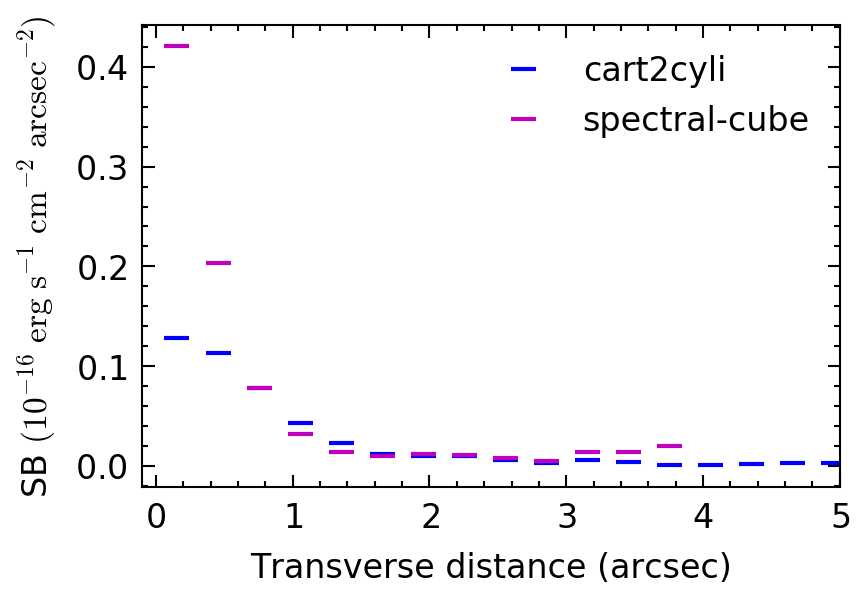

In [129]:
from scipy import interpolate

fn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli.fits".format(cubename.lower(),psname)
afn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli_area.fits".format(cubename.lower(),psname)
hdu = fits.open(fn)[0]
hdr = hdu.header

#adata = fits.open(afn)[0].data
cw=1216.9 # central wavelength
wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
vc = (wc / (1 + redshift) - cw) / cw *3e5
dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']

#am2d=np.nansum(adata,axis=2)
m2d=np.nanmean(hdu.data,axis=2)
print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
#interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
#r = interpolate.RectBivariateSpline(vc, dc, np.nan_to_num(m2d))

#interpfunc = lambda xnew, ynew: r(xnew, ynew).T

#interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
#xstack = np.arange(-1600, 2000, 50)
#ystack = np.arange(0, 25., 0.1)


#cp2d_new = interpfunc(xstack,ystack)




index_b = (vc > -1000) & (vc <= 0)
index_r = (vc > 0) & (vc <= 1200)
index_a = (vc > -1000) & (vc <= 1200)

sb_b0 = np.sum(m2d[index_b, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)
sb_r0 = np.sum(m2d[index_r, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)
sb_a0 = np.sum(m2d[index_a, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)

#asb_a0 = np.sum(am2d[index_a, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)

fig, ax = plt.subplots(figsize=(3,2),dpi=300)

ax.errorbar(dc,sb_b0
            ,fmt="_",
        label="cart2cyli",
        color="b",
        capsize=0.0,
        ls="None",
        lw=1)
ty=np.array([42.11899788, 20.3189102 ,  7.77915837,  3.14462739,  1.38252179,
        1.00454077,  1.1575351 ,  1.10231811,  0.79644328,  0.46233536,
        1.36576262,  1.39187972,  1.94364115,         np.nan,         np.nan,
               np.nan,         np.nan,         np.nan,         np.nan])
rbin=np.array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6, 3.9,
       4.2, 4.5, 4.8, 5.1, 5.4, 5.7])
ax.errorbar(rbin-0.15,ty*0.01
            ,fmt="_",
        label="spectral-cube",
        color='m',
        capsize=0.0,
        ls="None",
        lw=1)
#ax.plot(rbin[:-1]*kpc_per_arcsec+rx/2,np.array(annulus_value[sourcename][1])*2,color="k")

#ax.fill_between(rbin[:-1]*kpc_per_arcsec+rx/2,0,np.array(annulus_value[sourcename][1])*2,color="k",alpha=0.3)

#x_fit = np.linspace(3, 20, 100)
#y_fit=fitted_model(x_fit)
#ax.plot(x_fit,y_fit,"g")
ax.legend()
#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([-0.1,5])
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("Transverse distance (arcsec)")
ax.set_ylabel(r"SB $\rm (10^{-16}~erg~s^{-1}~cm^{-2}~arcsec^{-2})$")
#fig.savefig(KBSSpath+"/"+field+"/"+sourcename+"/kcwi_oned/SB_profile.pdf")


# 1. reproject PSF subtracted cube onto cylindrical system

In [245]:
from importlib import reload
reload(kcwi_tools)
#dkind=".PSFCONTSub"
overwrite=True
dkind=""
for psname in ["BX160"]:#enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if True:#Type=='QSO' or Type=='AGN/QSO':
        subdapath=KBSSpath+"/"+cubename+"/"+psname
        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs{}.fits".format(cubename.lower(),psname,dkind)
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
    else:
        print(psname,"is not type-1, skipping...")
        continue
    writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli.fits".format(cubename.lower(),psname)
    if overwrite==True or (not os.path.exists(writefn)):
        print("reprojecting",psname,"to cylindrical system...")
        hdu=fits.open(Subfile)
        hdu2=fits.open(cubefile)
        hdu[0].header["CNAME3"]=hdu2[0].header["CNAME3"]
        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writefn=writefn,montage=False,montagepy=False,clean=False)
    else:
        print("reprojected cube existed: no stacking performed ")


reprojecting BX160 to cylindrical system...


In [749]:
ypix,xpix

(42.25, 64.47)

### Do the same for HL QSOs

In [697]:
qsos_bright=ascii.read(KBSSpath+"/KCWI/qsos_bright.kcwi",format="ipac")
i=0
dryrun=False
for ind,field in enumerate(qsos_bright['Field']):
    sentry=qsos_bright[qsos_bright["Field"]==field]
    #cubename=sentry["Field"].value[0]
    #Type=sentry["Type"][0]
    if field=="1623":
        psname=sentry["Name"][i].split("-")[1]
        i+=1
        sentry=qsos_bright[(qsos_bright["Field"]==field) & (qsos_bright["Name"]==field+"-"+psname)]
        ssentry=qsos[qsos["Name"]==psname]
        csname=ssentry["Cube"][0]
        dapath=KBSSpath+"/"+field+"/"+csname+"/kcwi_oned"
        subdapath=KBSSpath+"/"+field+"/"+psname+"/kcwi_oned"
        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.fits".format(field.lower(),psname)
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
        writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli.fits".format(field.lower(),psname)
    else:
        subdapath=KBSSpath+"/"+field+"/QSO"
        Subfile = subdapath+"/{}-qso_icubes_wcs.fits".format(field.lower())
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
        writefn=subdapath+"/{}-qso_icubes_wcs.sat.cyli.fits".format(field.lower())
    if not os.path.exists(writefn):
        print("reprojecting",sentry["Name"][0],"to cylindrical system...")
        print("reading:",Subfile)
        print("writing result to ",writefn)
        if dryrun:
            continue
        hdu=fits.open(Subfile)
        hdu[0].header["CNAME3"]='KCWI Wavelength'
        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writefn=writefn)
    else:
        print("reprojected cube existed: no stacking performed ")


reprojecting Q0100+13 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0100/QSO/q0100-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0100/QSO/q0100-qso_icubes_wcs.sat.cyli.fits
reprojecting HS0105+1619 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0105/QSO/q0105-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0105/QSO/q0105-qso_icubes_wcs.sat.cyli.fits
reprojecting Q0142-10 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0142/QSO/q0142-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0142/QSO/q0142-qso_icubes_wcs.sat.cyli.fits
reprojecting Q0207-003 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0207/QSO/q0207-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0207/QSO/q0207-qso_icubes_wcs.sat.cyli.fits
reprojecting Q0821+3107 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0821/QSO/q0821-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS

FileNotFoundError: [Errno 2] No such file or directory: '/disk/bifrost/yuanze/KBSS/Q1623/QSO/q1623-qso_icubes_wcs.fits'

In [241]:
hdu=fits.open(Subfile)
hdu2=fits.open(cubefile)
hdu[0].header["CNAME3"]=hdu2[0].header["CNAME3"]
nhdu=kcwi_tools.cart2cyli(hdu2[0],[xpix,ypix],r_range=[0,10],clean=False,montage=True,montagepy=True)

maximum of data5: nan


In [234]:
testhdr=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_3.fits")

In [417]:
print(np.nanmax(testhdr[0].data))
print(np.nanmax(nhdu[0].data))

2.7166420655036454
49.22491697470347


In [231]:

hdu3_1=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_1.fits")[0]
hdu3_2=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_2.fits")[0]
hdu3_3=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_3.fits")[0]

data4=np.zeros((hdu3_1.shape[0],hdu3_1.shape[1],
                hdu3_1.shape[2]+hdu3_2.shape[2]+hdu3_3.shape[2]-30))
data4[:,:,0:hdu3_1.shape[2]-10]=hdu3_1.data[:,:,5:hdu3_1.shape[2]-5]
data4[:,:,hdu3_1.shape[2]-10:
        hdu3_1.shape[2]+hdu3_2.shape[2]-20]=hdu3_2.data[:,:,5:hdu3_2.shape[2]-5]
data4[:,:,hdu3_1.shape[2]+hdu3_2.shape[2]-20:
        hdu3_1.shape[2]+hdu3_2.shape[2]+hdu3_3.shape[2]-30]=hdu3_3.data[:,:,5:hdu3_3.shape[2]-5]
data4[data4==0]=np.nan

In [239]:
hdu3_3.shape[2]

130

In [233]:
dx=-hdu3_1.header['CD1_1']
dx0=-nhdu[0].header['CD1_1']
print(int(dx0/dx))
print(nhdu[0].header['CRVAL2'])

1
0


# 2. Stack cube together 

In [2]:
for ind,psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if Type=='QSO' or Type=='AGN/QSO':

SyntaxError: unexpected EOF while parsing (2507708774.py, line 5)

In [3]:
sourcename="BX172"
psname="BX164"

qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
sentry=qsos[qsos["Name"]==psname]
cubename=sentry["Field"].value[0]
Type=sentry["Type"][0]
if sentry["zneb"]>0:
    redshift=sentry["zneb"].value[0]
elif sentry["zabs"]>0:
    redshift=sentry["zabs"].value[0]
else:
    redshift=sentry["zlya"].value[0]
RA = sentry["RA"].value[0]
DEC = sentry["Dec"].value[0]
xpix = sentry["x"].value[0]
ypix = sentry["y"].value[0]

datapath=KBSSpath+"/"+cubename+"/"+sourcename
subdapath=KBSSpath+"/"+cubename+"/"+psname

cyli_cube=fits.open(subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname))

In [319]:
def create_axis(header, crval, cdelt, naxis):
    return np.arange(header[crval], header[crval] + cdelt * header[naxis], cdelt)


PA_axis=np.arange(cyli_cube[0].header['CRVAL1A'],cyli_cube[0].header['CRVAL1A']+cyli_cube[0].header['CD1_1A']*(cyli_cube[0].header['NAXIS1']),cyli_cube[0].header['CD1_1A'])
r_axis=np.arange(cyli_cube[0].header['CRVAL2A'],cyli_cube[0].header['CRVAL2A']+cyli_cube[0].header['CD2_2A']*(cyli_cube[0].header['NAXIS2']),cyli_cube[0].header['CD2_2A'])
spec_axis=np.arange(cyli_cube[0].header['CRVAL3A'],cyli_cube[0].header['CRVAL3A']+cyli_cube[0].header['CD3_3A']*(cyli_cube[0].header['NAXIS3']),cyli_cube[0].header['CD3_3A'])

In [352]:
coord=["01 03 11.27 +13 16 18.2",\
      "01 08 06.4  +16 35 50.0",\
       "01 45 16.6  -09 45 17.0",\
       "02 09 50.71 -00 05 06.5",\
       "04 52 14.3  -16 40 16.2",\
       "08 21 07.62 +31 07 51.17",\
       "10 11 55.60 +29 41 41.7",\
       "12 19 30.85 +49 40 51.2",\
       "14 44 53.67 +29 19 05.6",\
       "15 51 52.5  +19 11 04.3",\
       "16 04 55.38 +38 12 01.8",\
       "16 25 48.83 +26 46 58.8",\
       "16 25 48.1  +26 44 32.9",\
       "16 25 57.4  +26 44 48.5",\
       "17 01 00.6  +64 12 09.4",\
       "22 08 52.1  -19 43 59.7",\
       "23 46 28.30 +12 48 57.8"
      ]
for pos in coord:
    s=SkyCoord(pos,unit=(u.hourangle, u.deg))
    print(s)

<SkyCoord (ICRS): (ra, dec) in deg
    (15.79695833, 13.27172222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (17.02666667, 16.59722222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (26.31916667, -9.75472222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (32.46129167, -0.08513889)>
<SkyCoord (ICRS): (ra, dec) in deg
    (73.05958333, -16.67116667)>
<SkyCoord (ICRS): (ra, dec) in deg
    (125.28175, 31.13088056)>
<SkyCoord (ICRS): (ra, dec) in deg
    (152.98166667, 29.69491667)>
<SkyCoord (ICRS): (ra, dec) in deg
    (184.87854167, 49.68088889)>
<SkyCoord (ICRS): (ra, dec) in deg
    (221.223625, 29.31822222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (237.96875, 19.18452778)>
<SkyCoord (ICRS): (ra, dec) in deg
    (241.23075, 38.2005)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.45345833, 26.783)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.45041667, 26.74247222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.48916667, 26.74680556)>
<SkyCoord (ICRS): (ra, dec) in deg
    (255.2525, 64.20261111)>
<SkyCoor

In [99]:
wdir=f"{KBSSpath}/stack_analysis"
flist=[]
for ind,psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if Type=='QSO' or Type=='AGN/QSO':
        subdapath=KBSSpath+"/"+cubename+"/"+psname
#        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
        cyli_cube_name=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname)
        flist.append(cyli_cube_name)
#np.savetxt(wdir+"/source.list",np.array(flist).T,fmt='%s')

In [65]:
Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
Sub_cube = SpectralCube.read(Subfile)

In [339]:
QSOtab=qsos[((qsos['Type']=="QSO")|(qsos['Type']=="AGN/QSO"))& (qsos['R']>21)&(qsos['ext']=="True")]#&

In [340]:
result=stack_cp2d(QSOtab)

interpolating with grid:  (2599,) (50,) on (2599, 50)
interpolating with grid:  (2597,) (50,) on (2597, 50)


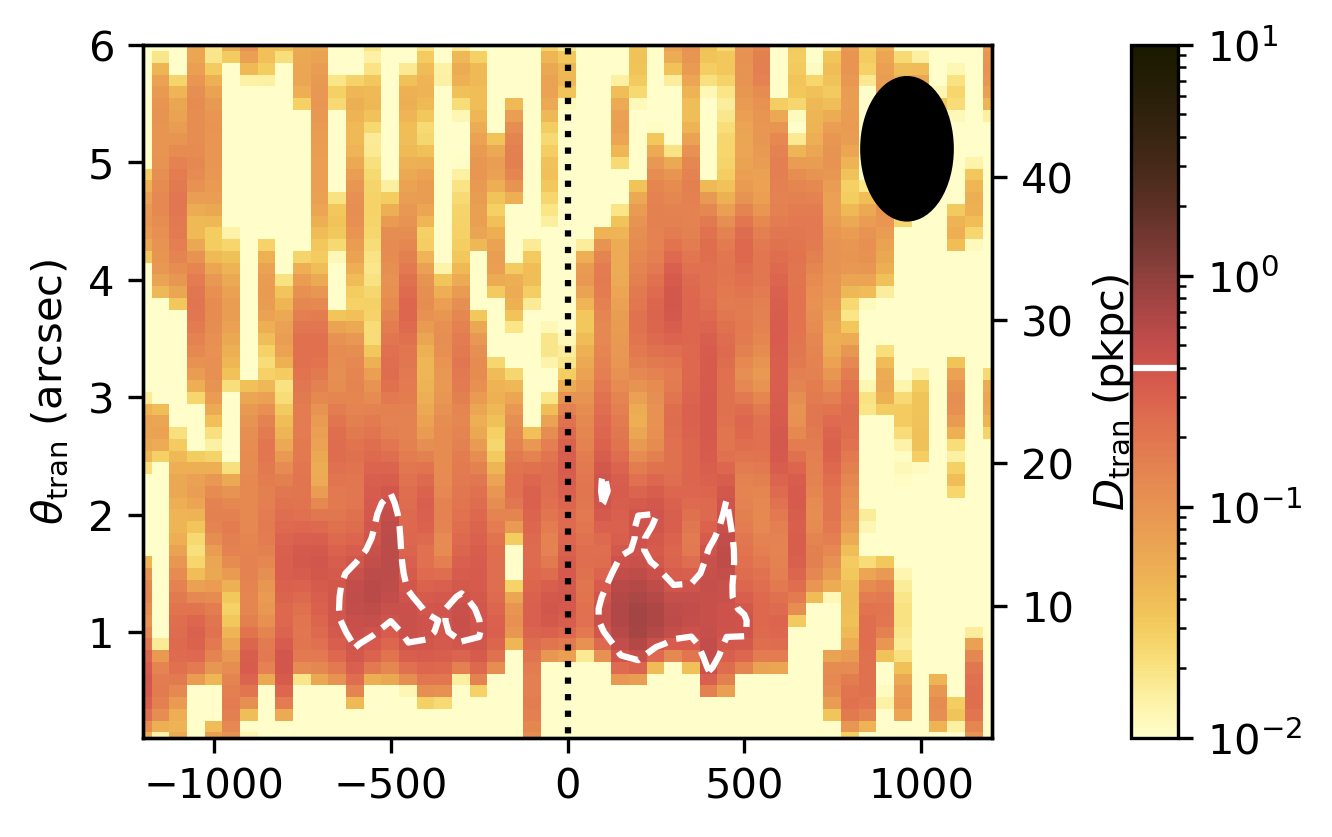

In [338]:
import common_tools
importlib.reload(common_tools)

fig, ax = plt.subplots(figsize=(5,3),dpi=300)

common_tools.plot_cp2d(result,fig,ax,log=True)
fig.savefig("/disk/bifrost/yuanze/KBSS/stack_analysis/fig/stack_ps_faintQSOs.pdf")

In [325]:
result.shape

(250, 53)

In [797]:
def stack_cp2d(tab, norm=None, med=False, return_cube=False, nsig=None, nboot=None, igmc=False, 
               get_vlyas=False, get_rprofile=False, cont=False, full=False, noism=False): 

    xnew = np.arange(-1300, 1350, 50)
    ynew = np.arange(0, 25., 0.1)
    xcorner = np.append(xnew, xnew[-1]+50) - 25
    ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
    xmesh, ymesh = np.meshgrid(xcorner, ycorner)
    xcmesh, ycmesh = np.meshgrid(xnew, ynew)
    
    xcont_new = np.arange(-20000, 20000, 100)
    ycont_new = np.arange(0, 10, 0.1)
    xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
    ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
    xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
    xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)
    
    wcont_full = np.arange(1000, 1700, 0.5)
    xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
    ycont_full = np.arange(0, 10, 0.1)
    dxcont = xcont_full[1] - xcont_full[0]
    xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
    ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
    xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
    xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)
    
    if med:
        stackfunc = np.nanmedian
    else:
        stackfunc = np.nanmean
        
    if cont:
        xstack, ystack = xcont_new, ycont_new
        get_vlyas = False
        if full:
            xstack, ystack = xcont_full, ycont_full
            get_vlyas = False
    else:
        xstack, ystack = xnew, ynew
    
    stackcube = np.zeros((len(tab), len(ystack), len(xstack)))
    
    for i, element in enumerate(tab):
        #field = element['FILENAME'].split('-')[0]
        field=element['Field']
        objname=element['Name']
        #Type=element["Type"]
        #if Type!='QSO' and Type=='AGN/QSO':
        #    continue
        subdapath=KBSSpath+"/"+field+"/"+objname
        fn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(field.lower(),objname)
        #fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME']+'-'+element['OBJECT']+'_cp2d_lya_csub_mask.fits'
        
        if igmc:
            fn = fn.replace('.fits', '_igmc.fits')
            
        if cont:
            fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME'] + '-' + element['OBJECT'] + '_cp2d_full_mask.fits'

        if noism:
            fn = '/Volumes/kbss-kcwi/tier3adv/' +field +'/twod/noism/' + element['FILENAME'] + '-' + element['OBJECT'] + '_cp2d_lya_csub_noism_mask.fits'
                
        hdu = fits.open(fn)[0]
        hdr = hdu.header

        #wc = (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CD1_1'] + hdr['CRVAL1']
        wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
        vc = (wc / (1 + element['zlya']) - 1215.67) / 1215.67 *3e5
        dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']
        
        # interpolation
        m2d=np.nansum(hdu.data,axis=2)
        print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
        interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
        cp2d_new = interpfunc(xstack, ystack)
        
        if norm is not None:
            cp2d_new = cp2d_new / norm[i]
        
        stackcube[i, :, :] = cp2d_new
        
    
    # safety 
    stackcube[stackcube == 0] = np.nan

    
    # sigma-clipping
    if nsig is not None:
        stackcube = astropy.stats.sigma_clip(stackcube, sigma=nsig, axis=0, masked=False)
        
    # stacked cp2d
    cp2d_stack = stackfunc(stackcube, axis=0)
        
    # bootstrap
    if nboot is not None:
        bootcube = np.zeros((nboot, len(ystack), len(xstack)))
        for i in range(nboot):
            rand = np.random.randint(0, len(tab)-1, size=len(tab))
            stackcube_rearrange = stackcube[rand, :, :]
            bootcube[i, :, :] = stackfunc(stackcube_rearrange, axis=0)
        
        booterr = np.nanstd(bootcube, axis=0)
        
    # vlyas
    if get_vlyas:
        vlyas0 = np.zeros((len(ynew), 16)) + np.nan
        # 16 params: v0, sigv, alpha, height, v0, sigv, alpha, height, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt
        if nboot is not None:
            vlyas_cube = np.zeros((nboot, len(ynew), 16)) + np.nan
        
        for i in tqdm(range(len(ynew))):
            if nboot is not None:
                fitmodel0, lyamodel0, ndim0, p0, psig0 = lya_bestmod(xnew, cp2d_stack[i, :], booterr[i, :])
            else:
                fitmodel0 = fit_lya_2
                lyamodel0 = lya_model
                p0, posig = fit_lya_2(xnew, cp2d_stack[i, :], np.ones_like(xnew), absolute_sigma=False, all_p=True)

            vlyas0[i, :8] = p0
            vlyas0[i, 8:] = calc_vlya(*p0)
            
            if nboot is not None:
                for j in range(nboot):
                    p0, _ = fitmodel0(xnew, bootcube[j, i, :], np.ones_like(xnew), all_p=True)
                    vlyas_cube[j, i, :8] = p0
                    vlyas_cube[j, i, 8:] = calc_vlya(*vlyas_cube[j, i, :8])

                # get error
                vlyas_cube[vlyas_cube == -9999] = np.nan
                vlyas_err = np.nanstd(vlyas_cube, axis=0)
                
    if get_rprofile:
        if cont:
            index_c = (xstack > 2000) & (xstack <= 5000)
            sb_c0 = np.sum(cp2d_stack[:, index_c], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

            if nboot is not None:
                sb_c_cube = np.zeros((nboot, len(ystack)))
                for j in range(nboot): 
                    sb_c_cube[j, :] = np.sum(bootcube[j, :, index_c], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

                sb_c_sig = np.std(sb_c_cube, axis=0)
        
        else:
            index_b = (xstack > -1000) & (xstack <= 0)
            index_r = (xstack > 0) & (xstack <= 1200)
            index_a = (xstack > -1000) & (xstack <= 1200)

            sb_b0 = np.sum(cp2d_stack[:, index_b], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
            sb_r0 = np.sum(cp2d_stack[:, index_r], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
            sb_a0 = np.sum(cp2d_stack[:, index_a], axis=1) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

            if nboot is not None:
                sb_b_cube = np.zeros((nboot, len(ystack)))
                sb_r_cube = np.zeros((nboot, len(ystack)))
                sb_a_cube = np.zeros((nboot, len(ystack)))
                for j in range(nboot): 
                    sb_b_cube[j, :] = np.sum(bootcube[j, :, index_b], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
                    sb_r_cube[j, :] = np.sum(bootcube[j, :, index_r], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)
                    sb_a_cube[j, :] = np.sum(bootcube[j, :, index_a], axis=0) * (xstack[1] - xstack[0]) / 3e5 * 1215.67 * (2.4 + 1)

                sb_b_sig = np.std(sb_b_cube, axis=0)
                sb_r_sig = np.std(sb_r_cube, axis=0)
                sb_a_sig = np.std(sb_a_cube, axis=0)
        
        
    
    if (return_cube==False) and (nboot is None):
        result = cp2d_stack
    else:
        result = [cp2d_stack]
        
        if return_cube:
            result.append(stackcube)
        if nboot is not None:
            result.append(booterr)
            
        if get_vlyas:
            result.append(vlyas0)
            if nboot is not None:
                result.append(vlyas_err)
                
        if get_rprofile:
            if cont:
                result.append((sb_c0))
            else:
                result.append((sb_b0, sb_r0, sb_a0))
                
            if nboot is not None:
                if cont:
                    result.append((sb_c_sig))
                else:
                    result.append((sb_b_sig, sb_r_sig, sb_a_sig))
    return result

In [798]:
tab=QSOtab
xnew = np.arange(-1300, 1350, 50)
ynew = np.arange(0, 15., 0.1)
xcorner = np.append(xnew, xnew[-1]+50) - 25
ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
xmesh, ymesh = np.meshgrid(xcorner, ycorner)
xcmesh, ycmesh = np.meshgrid(xnew, ynew)

xcont_new = np.arange(-20000, 20000, 100)
ycont_new = np.arange(0, 10, 0.1)
xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)

wcont_full = np.arange(1000, 1700, 0.5)
xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
ycont_full = np.arange(0, 10, 0.1)
dxcont = xcont_full[1] - xcont_full[0]
xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)

stackfunc = np.nanmean

xstack, ystack = xnew, ynew

stackcube = np.zeros((len(tab), len(ystack), len(xstack)))

for i, element in enumerate(tab):
    #field = element['FILENAME'].split('-')[0]
    field=element['Field']
    objname=element['Name']
    #Type=element["Type"]
    #if Type!='QSO' and Type=='AGN/QSO':
    #    continue
    subdapath=KBSSpath+"/"+field+"/"+objname
    fn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(field.lower(),objname)
    #fn = '/Volumes/kbss-kcwi/tier3adv/' + field + '/twod/' + element['FILENAME']+'-'+element['OBJECT']+'_cp2d_lya_csub_mask.fits'
                
    hdu = fits.open(fn)[0]
    hdr = hdu.header

    #wc = (np.arange(hdr['NAXIS1']) - hdr['CRPIX1'] + 1) * hdr['CD1_1'] + hdr['CRVAL1']
    wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
    vc = (wc / (1 + element['zlya']) - 1215.67) / 1215.67 *3e5
    dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']
    
    # interpolation
    m2d=np.nansum(hdu.data,axis=2)
    print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
    interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
    cp2d_new = interpfunc(xstack, ystack)
    
    stackcube[i, :, :] = cp2d_new


FileNotFoundError: [Errno 2] No such file or directory: '/disk/bifrost/yuanze/KBSS/Q0100/Q0100+13/kcwi_oned/q0100-Q0100+13_icubes_wcs.cyli.fits'

In [156]:
fn

'/disk/bifrost/yuanze/KBSS/Q2343/Q2343/kcwi_oned/q2343-Q2343_icubes_wcs.cyli.fits'

# 3. reproject PSF subtracted cube onto cylindrical system: Hyperluminous QSOs

## Read data and do the stacking

In [25]:
subhdu=fits.open("/disk/bifrost/yuanze/KBSS/Q0100/QSO/q0100-qso_icubes_wcs.fits")
psfhdu=fits.open("/disk/bifrost/yuanze/KBSS/CubEx_run/Q0100/psfout.fits")

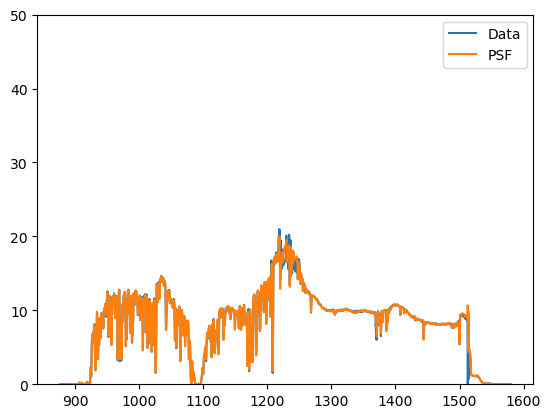

In [40]:
hdr=subhdu[0].header
wave=(np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
wave=wave/(1+2.686)
plt.plot(wave,subhdu[0].data[:,50,50],label="Data")
plt.plot(wave,psfhdu[0].data[:,50,50],label="PSF")
plt.ylim([-0.01,50])
#plt.xlim([1200,1240])

plt.legend()

In [256]:
np.max(psfhdu[0].data[:,xpos,50])

20.00784

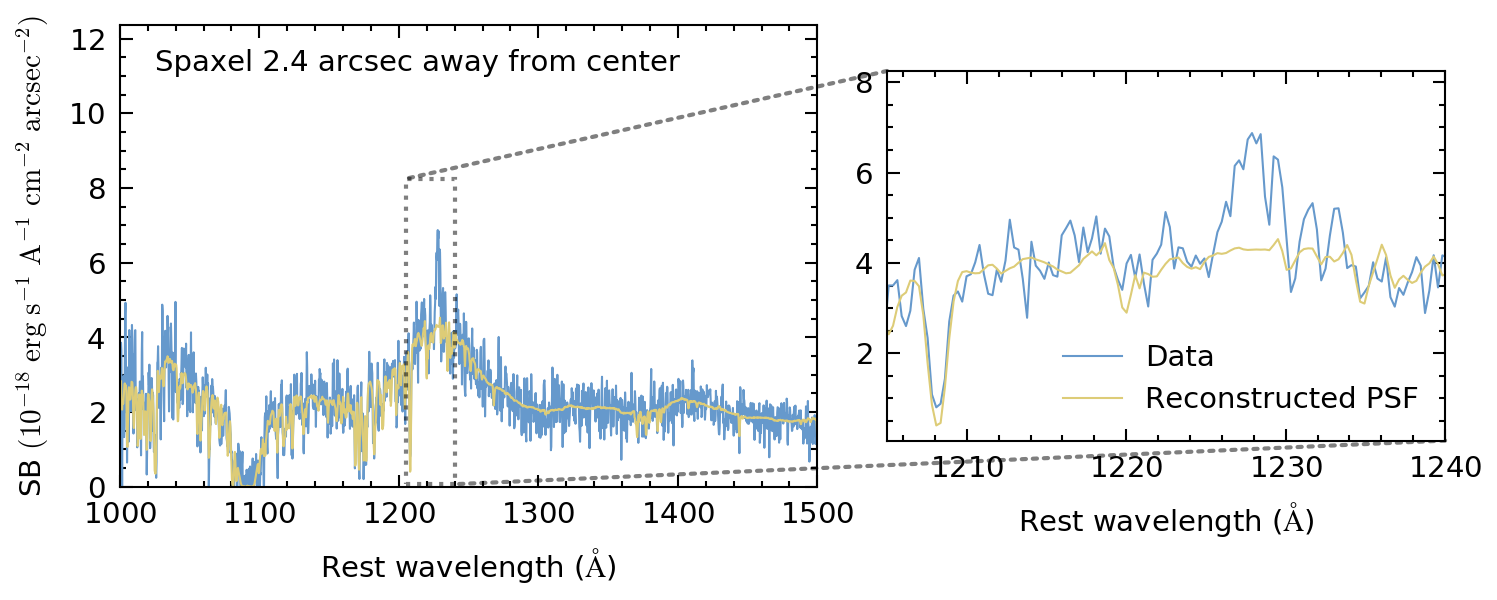

In [275]:
import scienceplots
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":7,
"legend.fancybox":True})
subhdu=fits.open("/disk/bifrost/yuanze/KBSS/Q0100/QSO/q0100-qso_icubes_wcs.fits")
psfhdu=fits.open("/disk/bifrost/yuanze/KBSS/CubEx_run/Q0100/psfout.fits")


colorlst=["#CC6677","#DDCC77","#6699CC"]
fig=plt.figure(figsize=(3,2),dpi=300)
#gs = fig.add_gridspec(1,1, hspace=0)
axs = plt.subplot()

lw=0.5
fac=1.0

hdr=subhdu[0].header
wave=(np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
wave=wave/(1+2.686)
xpos=42
ypos=50

efactor=100
ydasub=subhdu[0].data[:,xpos,ypos]*efactor
ydapsf=psfhdu[0].data[:,xpos,ypos]*efactor

axs.plot(wave,ydasub,colorlst[2],ms=0.5,label="Data",lw=lw)
axs.plot(wave,ydapsf,colorlst[1],ms=0.5,label="PSF",lw=lw)


axs.set_xlabel(r"Rest wavelength ($\rm \AA$)")
axs.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$")
axs.set_xlim([1000,1500])
axs.text(0.05,0.90,"Spaxel 2.4 arcsec away from center",transform=axs.transAxes)
#axs.text(0.05,0.84,r"Log$[\,\xi/$erg$\,$cm$\,$s$^{-1}]=%d $"%logxi,transform=axs.transAxes)
axs.set_ylim([0,1.8*np.max(ydasub[1000:2000])])


axins=axs.inset_axes([1.1,0.1,0.8,0.8])

axins.plot(wave,ydasub,colorlst[2],ms=0.5,label="Data",lw=lw)
axins.plot(wave,ydapsf,colorlst[1],ms=0.5,label="Reconstructed PSF",lw=lw)

axins.set_xlim([1205,1240])
axins.set_ylim([0.01*np.max(ydasub[1000:2000]),1.2*np.max(ydasub[1000:2000])])
#axins.set_xscale("log")
#axins.set_yscale("log")
axins.set_xlabel(r"Rest wavelength ($\rm \AA$)")
axins.legend()
rec,clines=axs.indicate_inset_zoom(axins,edgecolor="k",ls=':')
clines[2].set_linestyle(':')
clines[1].set_linestyle(':')
#clines[1].set(arrowstyle='wedge')
#axins.set_yticks([])
#axins.set_yticklabels([])
#ax3ins.axhline(y=1,c="k",lw=1)




#axs=plt.gca()
#plt.text(0.05,0.9,datype,transform=axs.transAxes)
fig.savefig(KBSSpath+"/fig/PSF_sub_outs.pdf")

In [7]:
qsos = ascii.read(KBSSpath+"/KCWI/qsos_bright_updated.list",format="ipac")
#QSOtab=qsos[(qsos['contam']=="False")&(qsos['Field']!="Q1623")]
#QSOtab=qsos#[(qsos['Field']!="Q0142")&(qsos['Field']!="Q1623")]
QSOtab=qsos#[(qsos['Field']=="Q0449")]

In [8]:
QSOtab

Name,Field,RA,Dec,x,y,EBV,z_simbad,z_sys,zerr,contam,u,g,r,i,z,MB,Comments,Mi,z_Lyaneb
unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,,
str11,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,str71,float64,float64
Q0100+13,Q0100,15.797,13.272,50.46,50.41,0.031,2.686,2.721,0.001,False,17.4,16.7,16.5,16.5,--,-26.4472,--,-30.321267391475878,2.72238484467835
HS0105+1619,Q0105,17.027,16.597,52.31,53.45,0.058,2.64,2.652,0.001,False,18.1,17.19,17.0,16.87,16.67,--,--,-29.88400104644006,2.6534598943518497
Q0207-003,Q0207,32.461,-0.085,49.95,50.93,0.024,2.85,2.872,0.001,False,18.08,17.02,16.92,16.84,16.76,--,--,-30.122461538584293,2.8743148248673793
Q0449-1645,Q0449,73.06,-15.329,52.06,51.32,0.046,2.6,2.6825,0.001,False,18.25,17.25,17.08,16.98,--,--,i-band apparent magnitude is estimated to be 17.00,-29.7854,2.6808366
Q0821+3107,Q0821,125.282,31.131,54.68,52.86,0.039,2.624,2.616,0.001,False,18.08,17.26,17.04,16.87,16.66,--,--,-29.848176827459962,2.6294241961367883
Q1009+29,Q1009,152.982,29.695,48.79,48.47,0.023,2.62,2.652,0.001,False,16.73,16.16,16.09,16.02,15.89,-26.7954,--,-30.73400104644006,2.651432107741275
Q1217+490,Q1217,184.879,49.681,47.9,43.83,0.015,2.698,2.704,0.001,False,17.77,17.09,16.92,16.79,16.7,-25.9884,--,-30.01486119098076,2.708454933359138
Q1442+2931,Q1442,221.224,29.318,51.0,45.68,0.015,2.638,2.66,0.001,True,17.31,16.41,16.41,16.33,16.09,--,"K=14.07,J=15.02",-30.431893073334017,2.664141101586948


In [387]:
importlib.reload(kcwi_tools)
radius=6
dovariance=False
doQSO=False
binwidth=20 #kpc
for ind,psname in enumerate(QSOtab['Name']):
    overwrite=False
    sentry=qsos[qsos["Name"]==psname]
    field=sentry["Field"].value[0]
   # if field != 'Q1623':
    subdapath=KBSSpath+"/"+field+"/QSO"
    if dovariance:
        Subfile = subdapath+"/{}-qso_vcubes.fits".format(field.lower())
        writefn=subdapath+"/{}-qso_vcubes_masked.cyli.fits".format(field.lower())
    elif doQSO:
        Subfile = subdapath+"/{}-qso_icubes_wcs.fits".format(field.lower())
        writefn=subdapath+"/{}-qso_icubes_wcs.sat.cyli.fits".format(field.lower())
    else:
        Subfile = subdapath+"/{}-qso_icubes_wcs_{}.PSFCONTSub.fits".format(field.lower(),int(radius/0.3))
        #writefn=subdapath+"/{}-qso_icubes_wcs_r{}_masked.cyli.fits".format(field.lower(),radius)
        writefn=subdapath+"/{}-qso_icubes_wcs_r{}_masked_Rhbinned_{}.cyli.fits".format(field.lower(),radius,binwidth)
    xpix = sentry["x"].value[0]
    ypix = sentry["y"].value[0]
        
    #else:
       # continue
        #name=sentry["Name"].split[1]
        #subdapath=KBSSpath+"/"+field+"/"+name
        #Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(field.lower(),name)
        #xpix = sentry["x"].value[0]
        #ypix = sentry["y"].value[0]
        #writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname)
    maskfn=subdapath+"/{}-{}_icubes_wcs_{}.PSFSub.mask.fits".format(field.lower(),"qso",int(radius/0.3))
    #if sentry["contam"]=="True":
    #    overwrite=True
    #    maskfn=subdapath+"/{}.reg".format(field)
    #else:
    #    maskfn=''
    if overwrite == True or (not os.path.exists(writefn)):
        print("reprojecting",psname,"to cylindrical system...")
        print("writing:",writefn)
        hdu=fits.open(Subfile)
        hdu[0].header["CNAME3"]="Wavelength"
        hdr=hdu[0].header
        status=kcwi_tools.cart2cyli(Subfile,[xpix,ypix],hdr=hdr,masktype='direct',cos=Planck18,r_range=[0,10],dr=binwidth/kpc_per_arcsec,maskfn=maskfn,writefn=writefn,montage=True)
        #status=kcwi_tools.cart2cyli(Subfile,[xpix,ypix],hdr=hdr,masktype='direct',cos=Planck18,r_range=[0,10],dr=0.3,maskfn=maskfn,writefn=writefn,montage=True)
        hdu.close()
    else:
        print(f"reprojected cube existed for {psname:s}: no stacking performed ")


reprojecting Q0100+13 to cylindrical system...
writing: /disk/bifrost/yuanze/KBSS/Q0100/QSO/q0100-qso_icubes_wcs_r6_masked_Rhbinned_20.cyli.fits
reading HDU
updating hdr
Using direct mask
Projecting FITS mask to mask_3d...
{'status': '0', 'time': 2.0}
reprojecting HS0105+1619 to cylindrical system...
writing: /disk/bifrost/yuanze/KBSS/Q0105/QSO/q0105-qso_icubes_wcs_r6_masked_Rhbinned_20.cyli.fits
reading HDU
updating hdr
Using direct mask
Projecting FITS mask to mask_3d...
{'status': '0', 'time': 1.0}
reprojecting Q0207-003 to cylindrical system...
writing: /disk/bifrost/yuanze/KBSS/Q0207/QSO/q0207-qso_icubes_wcs_r6_masked_Rhbinned_20.cyli.fits
reading HDU
updating hdr
Using direct mask
Projecting FITS mask to mask_3d...
{'status': '0', 'time': 2.0}
reprojecting Q0449-1645 to cylindrical system...
writing: /disk/bifrost/yuanze/KBSS/Q0449/QSO/q0449-qso_icubes_wcs_r6_masked_Rhbinned_20.cyli.fits
reading HDU
updating hdr
Using direct mask
Projecting FITS mask to mask_3d...
{'status': '0',

## Reprojection completed! Do the stacking.

#### Grid setup

In [10]:
xnew = np.arange(-4000, 3000, 40)
ynew = np.arange(1.2, 7.2, 0.1)
ynew_qso = np.arange(0.3, 3.0, 0.1)

kpc_per_arcsec = Planck18.kpc_proper_per_arcmin(2.65).value/60
ynew_rh = np.arange(0,60/kpc_per_arcsec,20/kpc_per_arcsec)
xcorner = np.append(xnew, xnew[-1]+50) - 25
ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
xmesh, ymesh = np.meshgrid(xcorner, ycorner)
xcmesh, ycmesh = np.meshgrid(xnew, ynew)

xcont_new = np.arange(-20000, 20000, 100)
ycont_new = np.arange(0, 10, 0.1)
xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)

wcont_full = np.arange(1000, 1700, 0.5)
xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
ycont_full = np.arange(0, 10, 0.1)
dxcont = xcont_full[1] - xcont_full[0]
xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)

In [5]:
QSOtab=qsos

In [180]:
hdu=fits.open("/disk/bifrost/yuanze/KBSS/Q1700/QSO/q1700-qso_icubes_wcs_r6_masked_Rhbinned.cyli.fits")
m2d=np.nanmean(hdu[0].data,axis=2)

/disk/bifrost/yuanze/anaconda3/envs/kcwidrp/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [6]:
QSOtab

RA,Dec,x,y,Cube,Name,Field,R,G-Rs,Un-G,ext,zlya,zabs,zneb,Type,Comments
unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit,unit
float64,float64,float64,float64,str6,str8,str5,float64,float64,float64,str5,float64,float64,float64,str3,str111
15.78142,13.28404,64.47,42.25,BX160,BX160,Q0100,24.43,0.13,0.4,False,2.306,2.296,2.3032,QSO,"""nz; m3[ap1]; also m6,m7,m10[ap1]; WISE undetected"""
15.78195,13.27525,77.63,27.28,BX172,BX164,Q0100,23.61,-0.03,0.71,False,2.293,-2.0,2.2924,QSO,"""mult masks; WISE undetected"""
15.78524,13.27826,38.9,62.8,BX172,BX172,Q0100,23.5,0.26,0.81,True,2.312,2.3077,2.3118,AGN,""" WISE undetected"""
26.32376,-9.74838,40.27,75.42,BX195,BX195,Q0142,23.56,0.53,0.98,False,2.3816,2.379,2.3807,AGN,"""zneb msfr3 9/15, has herschel; WISE undetected"""
26.32285,-9.75222,50.16,28.81,BX195,BX186,Q0142,25.18,0.39,0.61,False,2.361,2.354,2.357,AGN,"""zneb msfr3 9/15 (among others), has herschel; WISE undetected"""
32.47523,-0.07491,47.2,66.6,BX298,BX298,Q0207,25.07,0.03,0.73,True,2.1458,-2.0,2.1454,AGN,"""LM1; zneb msfr Nov 2014, close2; also jhk1 oct15, has herschel; WISE undetected"""
125.24689,31.14935,51.58,52.19,D8,D8,Q0821,24.76,0.57,2.53,True,2.5697,-2.0,2.5675,AGN,"""LM1; zneb=2.5678 mosfire 3/13+4/14+2/15; nz; m3+m10; z(HeII)=2.5658; has NV,CIV,HeII em; WISE undetected"""
125.22895,31.09895,37.18,52.53,RK5,RK5,Q0821,24.37,0.93,0.93,True,2.1846,-1.0,2.1831,QSO,"""rk_H,K; zneb msfr, great continuum detection w/Balmer ab"


In [113]:
from scipy import interpolate
cp2d_new = np.full((len(xnew), len(ynew_rh)),fill_value=np.nan)
print("warning: Radial interpolation is off, using the original grid")
for col in range(m2d.shape[1]):
    mask = ~np.isnan(m2d[:, col])
    if np.any(mask):
        f = interpolate.interp1d(np.where(mask)[0], m2d[mask, col], kind='linear', fill_value="extrapolate")
        cp2d_new[:, col] = f(xnew).T

In [11]:
importlib.reload(kcwi_tools)
importlib.reload(common_tools_yd)
radius=6
QSOtab=qsos#[(qsos['Field']!="Q0449")]
result=common_tools_yd.stack_cp2d(QSOtab,get_rprofile=True,refz="sys",interpR=True,return_cube=True,nboot=40,get_vlyas=True,radius=radius,stackgrid=(xnew,ynew_rh))
#result_var=common_tools_yd.stack_cp2d(QSOtab,get_rprofile=True,return_cube=True,get_vlyas=False,nboot=40,radius=radius,stackgrid=(xnew,ynew),variance=True)

#result_QSO=common_tools_yd.stack_cp2d(QSOtab,get_rprofile=True,return_cube=True,get_vlyas=False,nboot=40,radius=radius,stackgrid=(xnew,ynew_qso),QSO=True)

Radius: 6
interpolating with grid:  (2597,) (33,) on (2597, 33)
Radius: 6
interpolating with grid:  (2596,) (33,) on (2596, 33)
Radius: 6
interpolating with grid:  (2596,) (33,) on (2596, 33)
Radius: 6
interpolating with grid:  (2596,) (33,) on (2596, 33)
Radius: 6
interpolating with grid:  (2596,) (33,) on (2596, 33)
Radius: 6
interpolating with grid:  (2595,) (33,) on (2595, 33)
Radius: 6
interpolating with grid:  (2594,) (33,) on (2594, 33)
Radius: 6


/disk/bifrost/yuanze/software/KcwiKit/py/common_tools_yd.py:1224: RuntimeWarning: Mean of empty slice
  m2d=np.nanmean(hdu.data,axis=2)


interpolating with grid:  (2595,) (33,) on (2595, 33)
Radius: 6
interpolating with grid:  (2595,) (33,) on (2595, 33)
Radius: 6
interpolating with grid:  (2594,) (33,) on (2594, 33)
Radius: 6
interpolating with grid:  (2597,) (40,) on (2597, 40)
Radius: 6
interpolating with grid:  (2595,) (33,) on (2595, 33)
Radius: 6
interpolating with grid:  (2599,) (33,) on (2599, 33)
Radius: 6
interpolating with grid:  (2601,) (33,) on (2601, 33)


  0%|          | 0/4 [00:00<?, ?it/s]/disk/bifrost/yuanze/anaconda3/envs/kcwidrp/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
100%|██████████| 4/4 [00:12<00:00,  3.03s/it]


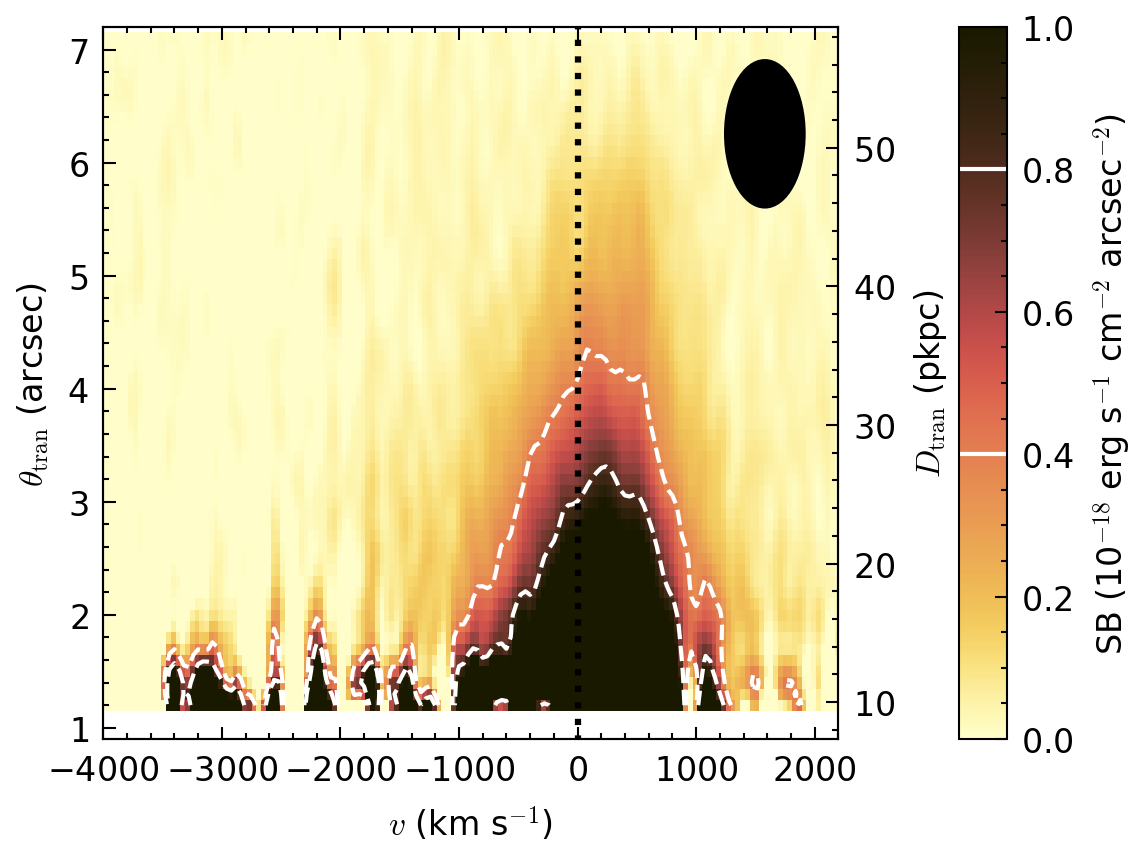

In [384]:
#import common_tools
#importlib.reload(common_tools)
importlib.reload(common_tools_yd)
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fig, ax = plt.subplots(figsize=(4,3),dpi=300)

common_tools_yd.plot_cp2d(result[0]*100,fig,ax,log=False,PSFSub=True,HL=True,cosmo=Planck18,stackgrid=(xnew,ynew))
fig.tight_layout()

fig.savefig("/disk/bifrost/yuanze/KBSS/QSOs_r{}_masked_pub2/stack_ps_HLQSOs.pdf".format(radius))

In [53]:
S2011=np.genfromtxt(KBSSpath+"/Steidel2011.csv",delimiter=",")
B2016=np.genfromtxt(KBSSpath+"/Borisova2016.csv",delimiter=",")
F2019=np.genfromtxt(KBSSpath+"/FAB2019.csv",delimiter=",")


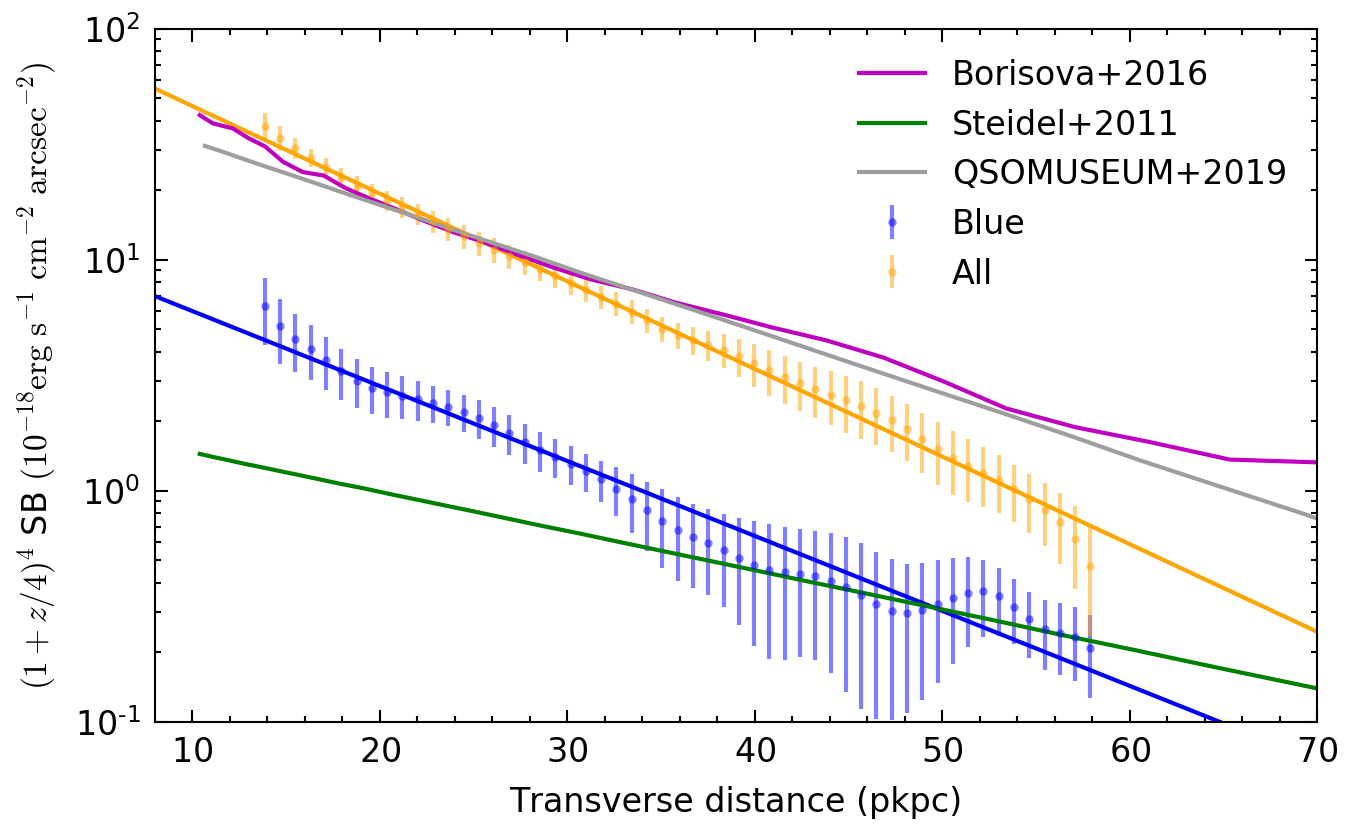

In [383]:
from astropy.modeling import Fittable1DModel, Parameter
import emcee
from scipy.optimize import curve_fit
from scipy import signal
from importlib import reload
reload(common_tools_yd)
from common_tools_yd import spatial_profile_2exp,spatial_profile_1exp
class OffsetExponential1D(Fittable1DModel):
    amplitude = Parameter()
    tau = Parameter()
    offset = Parameter()
    x_offset = Parameter()

    @staticmethod
    def evaluate(x, amplitude, tau, offset, x_offset):
        return amplitude * np.exp(-(x - x_offset) / tau) + offset

    @staticmethod
    def fit_deriv(x, amplitude, tau, offset, x_offset):
        exp_term = np.exp(-(x - x_offset) / tau)
        d_amplitude = exp_term
        d_tau = amplitude * (x - x_offset) * exp_term / tau**2
        d_offset = np.ones_like(x)
        d_x_offset = amplitude * exp_term / tau
        return [d_amplitude, d_tau, d_offset, d_x_offset]
'''
def log_likelihood(theta, x, y, yerr, model):
    model.parameters = theta
    y_model = model(x)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - y_model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    amp_exp, tau_exp, offset_exp, x_offset_exp, amp_pow, x0_pow, alpha_pow, amp_exp2, tau_exp2 = theta
    if (0 < amp_exp < 100 and 0 < tau_exp < 50 and -10 < offset_exp < 10 and 0 < x_offset_exp < 50 and
        0 < amp_pow < 100 and 0 < x0_pow < 50 and -5 < alpha_pow < 5 and 0 < amp_exp2 < 100 and -50 < tau_exp2 < 0):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr, model):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, model)
'''
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fig, ax = plt.subplots(figsize=(5,3),dpi=300)

initial_guess2 = [1, 10, 1, 30]  # Initial guess for the parameters
initial_guess1 = [1, 10]
#fitfunc=spatial_profile_2exp
fitfunc=spatial_profile_1exp

kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60
cut1=5
cut2=60
scolor=["Blue","Red","All"]
colorl=["b","r","orange"]
ffunc=[spatial_profile_1exp,spatial_profile_1exp,spatial_profile_1exp]
sresult={}
for side in [0,2]:
    fitfunc=ffunc[side]
    #if side == 0:
     #   initial_guess=initial_guess2
    #else:
    initial_guess=initial_guess1
    x_data=ynew[cut1:cut2]*kpc_per_arcsec
    y_data=result[5][side][cut1:cut2]*100*((1+2.65)/4)**4
    y_err=result[6][side][cut1:cut2]*100*((1+2.65)/4)**4
    ax.errorbar(x_data,y_data,yerr=y_err
                ,fmt="o",
            label=scolor[side],
            color=colorl[side],
                mfc="none",
                ms=1.,
            capsize=0.0,
            ls="None",
                alpha=0.5,
            lw=1)
    #model=models.Moffat1D(amplitude=1e-17,x_0=0)
    #model.x_0.fixed=True
    # Fit the model
    fcut=60
    params, covariance = curve_fit(fitfunc, x_data[:fcut], y_data[:fcut], p0=initial_guess,sigma=y_err[:fcut], absolute_sigma=True)
    sresult[scolor[side]]=params
    #fitted_model = fitter(model,x_data[:fcut],y_data[:fcut],weights=1/y_err[:fcut]**2)
    x_fit = np.linspace(8,70, 100)
    #y_fit=fitted_model(x_fit)
    y_fit=fitfunc(x_fit, *params)
    
    #y_fit_comp1=fitfunc(x_fit,params[0],params[1],0,1)
    #y_fit_comp2=fitfunc(x_fit,0,1,params[2],params[3])
    ax.plot(x_fit,y_fit,color=colorl[side])
    #if side==0:
        #ax.plot(x_fit,y_fit_comp1,ls="--",color=colorl[side],lw=0.5)
        #ax.plot(x_fit,y_fit_comp2,ls="--",color=colorl[side],lw=0.5)

ax.plot(B2016[:,0],B2016[:,1]*1e18,color="m",label="Borisova+2016")
ax.plot(S2011[:,0],S2011[:,1]*1e18,color="g",label="Steidel+2011")
ax.plot(F2019[:,0],F2019[:,1]*1e18*((1+3.15)/4)**4,color="C6",label="QSOMUSEUM+2019")

#ax.plot(x_fit,fitted_model[1](x_fit),"r")
#ax.axvline(kpc_per_arcsec*0.3*15,ls="--",lw=0.5)
#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([8,70])
ax.set_ylim([0.1,100])
ax.set_yscale("log")
#ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Transverse distance (pkpc)")
#ax.set_xlabel("Transverse distance (arcsec)")

ax.set_ylabel(r"$(1+z/4)^{4}$ SB $\rm (10^{-18} erg~s^{-1}~cm^{-2}~arcsec^{-2})$")

fig.savefig(KBSSpath+"/QSOs_r{}_masked_pub2/SB_profile.pdf".format(radius))
# try rmax at 6 arcsec?

In [56]:
print(sresult)
print(5.24/kpc_per_arcsec)

{'Blue': array([12.03997615, 16.16113575, 53.0808128 ,  5.24706642]), 'All': array([  95.03836717,   12.60618596, 1031.80376982,    2.88465515])}
0.6425949636301856


In [910]:
sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 5000/5000 [00:29<00:00, 167.03it/s]


State([[60.45029813 19.83016194 -7.05239713 19.48405549 42.5641912   8.70701191
  -4.26984979 83.16412684 -2.25946659]
 [92.51855785 15.83876409 -3.67083219 12.52478654 45.47528703 45.87626479
  -1.06603639 18.71659208 -6.40995663]
 [58.25111324 21.86775873 -9.67150377 20.25781706 34.45934619  7.40916815
  -4.52486402 66.73243581 -2.149657  ]
 [97.17328615 23.03587861 -9.45581059  7.21429206 54.56201669  6.87776553
  -3.4353139  23.06421259 -2.63287018]
 [75.19075015 22.91902158 -8.42737894 11.21536838 97.73090488 44.23614162
  -1.40047489 68.9905179  -4.53146485]
 [70.37153368 19.64127955 -7.89260772 17.82673447 95.97178926  6.52180229
  -3.86462788 37.51411652 -1.96643117]
 [80.45904072 22.6532786  -9.8665877  13.10162771 63.69372752  5.81970649
  -4.32932389 21.22435831 -2.07898295]
 [43.34147551 14.48764062 -3.90844288 26.67144134 20.89692004 43.05206441
  -3.32585589 40.37597026 -0.611344  ]
 [45.48009868 22.13225473 -8.08182533 23.76457897 49.47895479 13.70602829
  -2.0627833  73

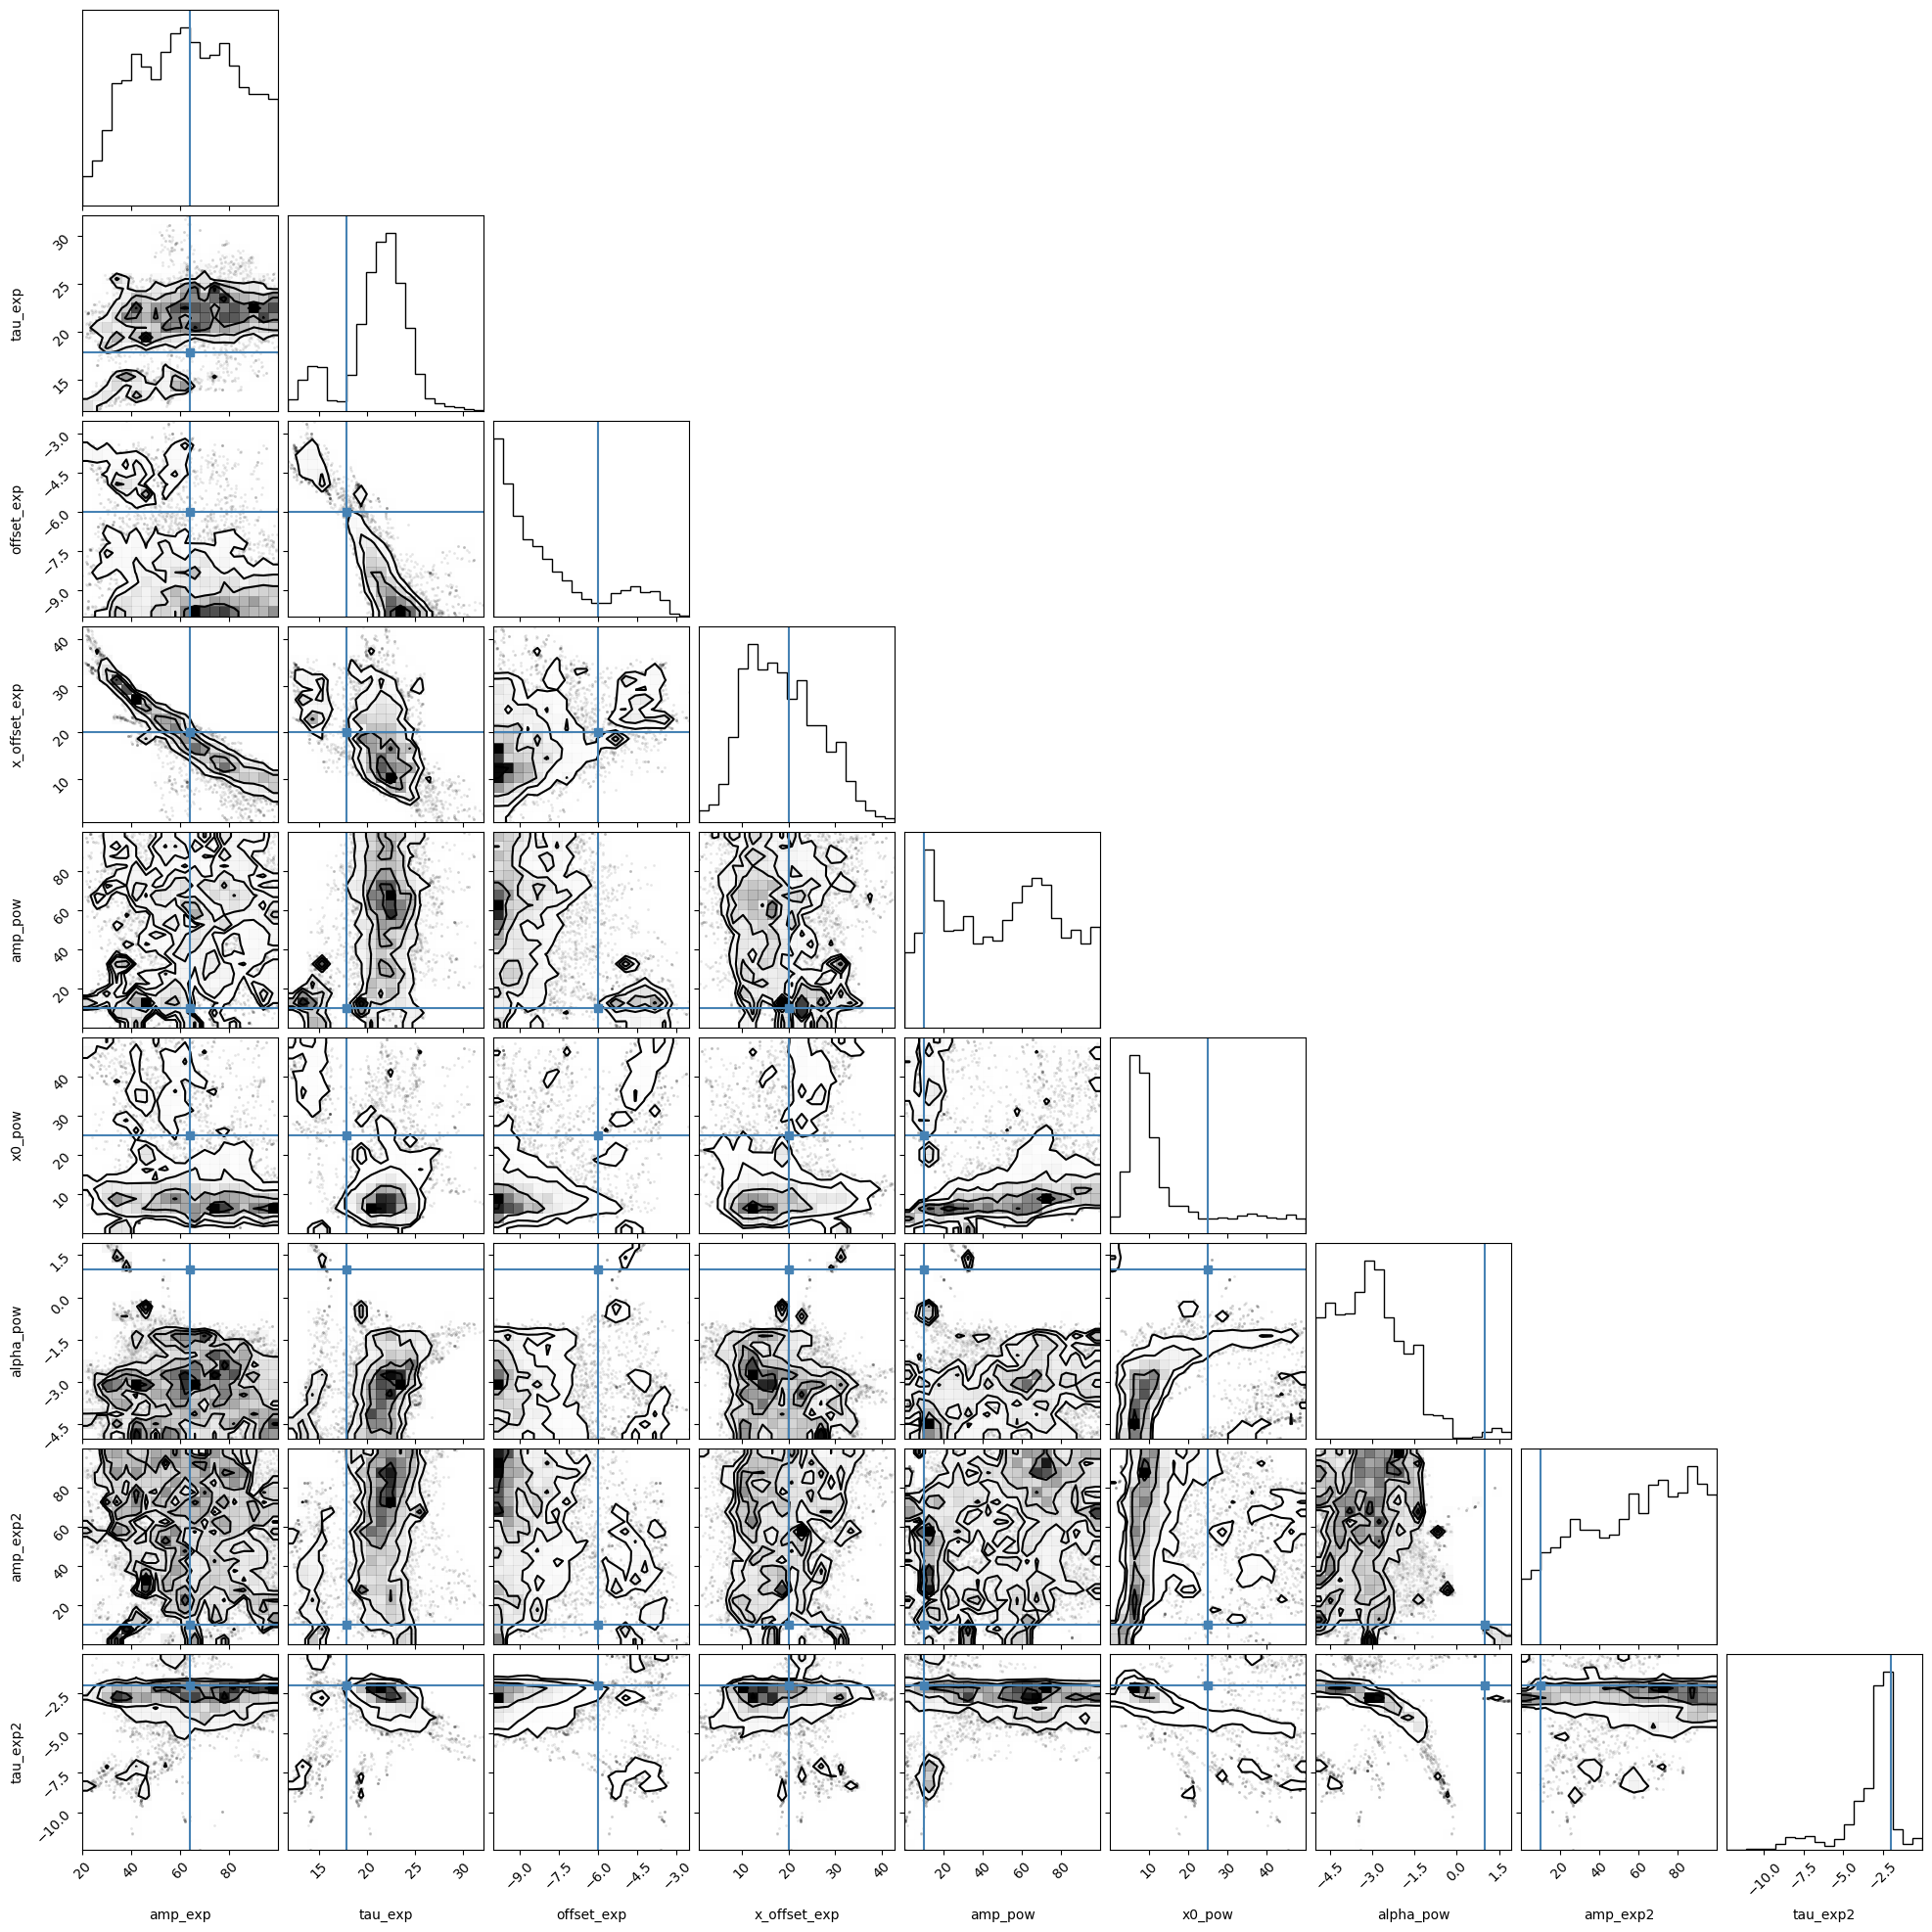

Parameter 1: 62.637 +22.799 -22.492
Parameter 2: 21.553 +2.289 -3.016
Parameter 3: -8.645 +3.144 -1.054
Parameter 4: 17.887 +9.562 -7.119
Parameter 5: 52.905 +28.066 -37.780
Parameter 6: 9.764 +20.350 -3.948
Parameter 7: -3.083 +1.370 -1.267
Parameter 8: 59.437 +28.229 -35.945
Parameter 9: -2.745 +0.684 -1.572


In [911]:
import corner

# Discard burn-in samples and flatten the chain
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Plot the corner plot
fig = corner.corner(flat_samples, labels=["amp_exp", "tau_exp", "offset_exp", "x_offset_exp",
                                          "amp_pow", "x0_pow", "alpha_pow", "amp_exp2", "tau_exp2"],
                    truths=initial)
plt.show()

# Calculate the statistics for the parameters
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"Parameter {i+1}: {mcmc[1]:.3f} +{q[1]:.3f} -{q[0]:.3f}")

In [860]:
fig, ax = plt.subplots(figsize=(5,3),dpi=300)

kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60
cut1=0
cut2=32
side=2
x_data=kpc_per_arcsec*ynew[cut1:cut2]
y_data=result[3][side][cut1:cut2]
y_err=result[4][side][cut1:cut2]
ax.errorbar(x_data,y_data,yerr=result[6][side][cut1:]
            ,fmt="o",
        #label="(Obs-Mod)/Obs",
        color="b",
            mfc="none",
            ms=1.,
        capsize=0.0,
        ls="None",
        lw=1)
#ax.plot(rbin[:-1]*kpc_per_arcsec+rx/2,np.array(annulus_value[sourcename][1])*2,color="k")

#ax.fill_between(rbin[:-1]*kpc_per_arcsec+rx/2,0,np.array(annulus_value[sourcename][1])*2,color="k",alpha=0.3)
model= OffsetExponential1D(amplitude=64, tau=17.8, offset=-6, x_offset=20)\
+models.PowerLaw1D(amplitude=10,x_0=25.,alpha=1.)*models.Exponential1D(amplitude=10,tau=-2)

model.amplitude_1.fixed=True
'''
# Initial guess for parameters
initial = np.array([64, 17.8, -6, 20, 10, 25, 1, 10, -2])
ndim = len(initial)
nwalkers = 32

# Initialize walkers near the initial guess
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
#for i in range(nwalkers):
#    print(f"Walker {i} initial position: {pos[i]}")
#    print(f"Walker {i} log_prior: {log_likelihood(pos[i],x_data,y_data,y_err,model)}")
# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_data, y_data, y_err, model))

# Run the MCMC chain
nsteps = 5000
'''


fitter = fitting.LevMarLSQFitter()
# Fit the model
fitted_model = fitter(model,x_data,y_data,weights=1/y_err**2)
#print(fitted_model)

x_fit = np.linspace(3, 70, 100)
y_fit=fitted_model(x_fit)
ax.plot(x_fit,y_fit,"g")
ax.axvline(kpc_per_arcsec*0.3*15,ls="--")
#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([6,70])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Transverse distance (pkpc)")
ax.set_ylabel(r"SB $\rm (10^{-16}~erg~s^{-1}~cm^{-2})$")

array([199.03212249, 199.03212249, 182.73487192, 185.34601486,
       172.33294834, 147.61251538, 142.5696815 , 159.89174322,
       163.98678241, 140.71866285, 107.2577014 ,  79.16157222,
        56.84775243,  40.22541174,  31.35962218,  26.48018262,
        23.39153986,  21.42185379,  19.31162014,  17.08477118,
        15.20533833,  13.81433039,  12.72602658,  11.75040206,
        10.8082495 ,   9.93090003,   9.15381401,   8.4892956 ,
         7.92390362,   7.43299572,   6.99998459,   6.62000877,
         6.2822698 ,   5.96666319,   5.65198526,   5.32333457,
         4.98536371,   4.65845374,   4.35497175,   4.07990558,
         3.84043043,   3.64531884,   3.49796875,   3.39620121,
         3.33985151,   3.33554156,   3.38918568,   3.49647327,
         3.62535175,   3.71636767,   3.70688001,   3.59570175,
         3.44386827,   3.3107994 ,   3.21402577,   3.13206468,
         3.04081816,   2.92904208,   2.79752388,   2.64406344,
         2.47333413,   2.2969717 ,   2.1219061 ,   1.95

In [230]:
#16 params: v0, sigv, alpha, height, v0, sigv, alpha, height, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt
vgrid = np.arange(-5500, 5501, 1)
#vgrid=xnew

IndexError: index 4 is out of bounds for axis 0 with size 4

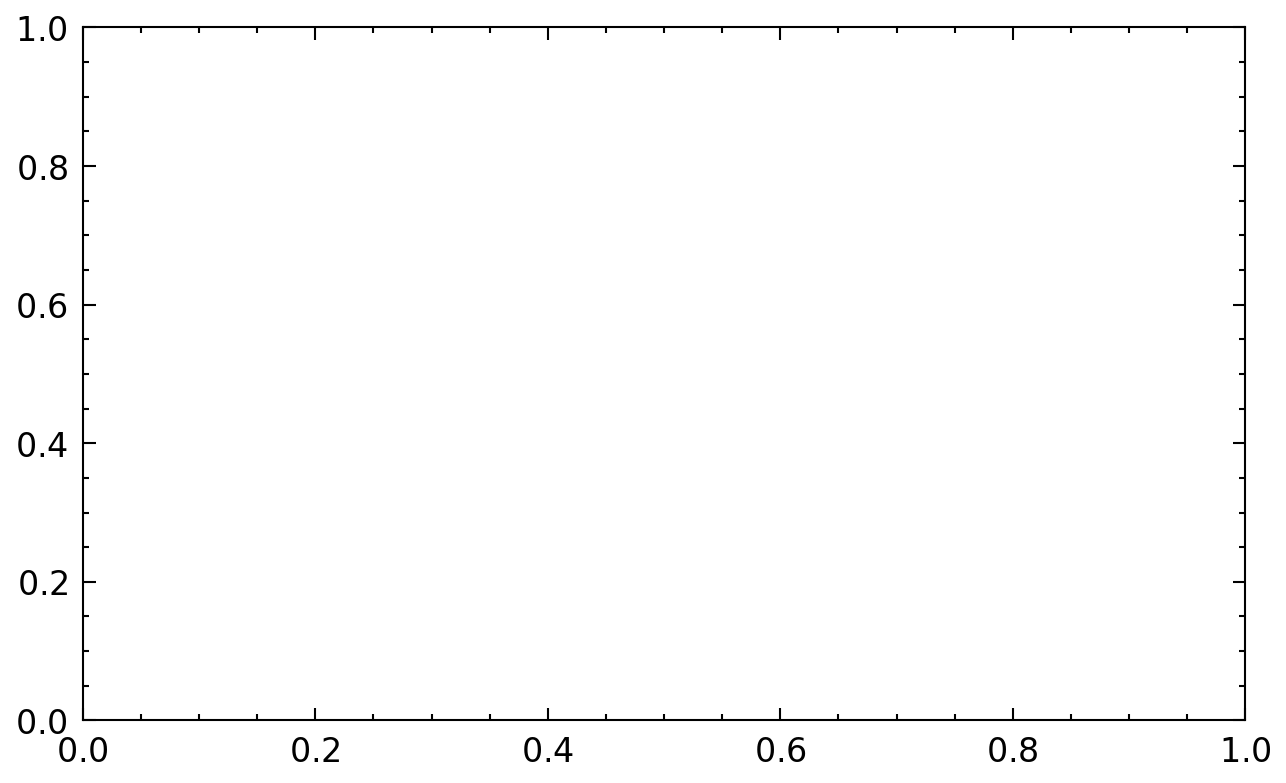

In [392]:
#for xind in range(31):
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
efactor=100
cind=0
plotmodel=True
plotQSO=False
normalize=False
if plotQSO:
    cmean,cmedian,_   =sigma_clipped_stats(result_QSO[0][cind,:],maxiters=None)
    cmax=np.max(result_QSO[0][cind,:]-cmedian)
#csmean,csmedian,_=sigma_clipped_stats(result_QSO[0][cind,:]-cmedian,maxiters=None)
for xind in range(58):
    if normalize:
        wc=(xnew/3e5*1215.67+1215.67)*(1+2.65) 
        efactor=1/np.trapz(result[0][xind,:],x=wc)
    fig, ax = plt.subplots(figsize=(5,3),dpi=300)
    if plotmodel:
        p00, p01, p02, p03, p10, p11, p12, p13, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt=result[3][xind,:]
        p00err, p01err, p02err, p03err, p10err, p11err, p12err, p13err, p0err, vp0err, fwhm0err, p1err, vp1err, fwhm1err, trougherr, vterr=result[4][xind,:]
        if p13<0:
            mod = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
            string=f"FWHM = {fwhm1:.1f}$\pm${fwhm1err:.1f}; Velocity = {vp1:.1f}$\pm${vp1err:.1f}; skewness = {p02:.1f}$\pm${p02err:.1f}"
        else:
            mod = common_tools_yd.lya_model_2(vgrid, p00, p01, p02, p03, p10, p11, p12, p13)
            mod1 = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
            mod2 = common_tools_yd.skew_gauss(vgrid, p10, p11, p12, p13)

            ax.plot(vgrid,mod1*efactor,"C2",label="Component 1",lw=1.0)
            ax.plot(vgrid,mod2*efactor,"C3",label="Component 2",lw=1.0)

            #np.savetxt(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod1.txt",np.array([vgrid,mod1*efactor]).T)
            #np.savetxt(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod2.txt",np.array([vgrid,mod2*efactor]).T)


            string=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.1f}, {fwhm1:.0f}$\pm${fwhm1err:.1f}; Velocity = {vp0:.1f}$\pm${vp0err:.1f}, {vp1:.1f}$\pm${vp1err:.1f};"+"\n"\
            +f"skewness = {p02:.1f}$\pm${p02err:.1f}, {p12:.1f}$\pm${p12err:.1f}; Peak = {p0*efactor:.1f}$\pm${p0err*efactor:.1f}, {p1*efactor:.1f}$\pm${p1err*efactor:.1f}"
            if np.isfinite(trough):
                string+=f"\n trough at {vt:.1f}$\pm${vterr:.1f}"
        ax.text(0.05,0.85,string,transform=ax.transAxes,color="k",fontsize=6)
        ax.plot(vgrid,mod*efactor,"--C1",label="Full model")
        
        
    ax.errorbar(xnew,result[0][xind,:]*efactor,yerr=result[2][xind,:]*efactor,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
    
    #ax.step(xnew,np.sqrt(result_var[0][xind,:])*efactor,lw=0.5,ls="--",color="red",label="Std. dev.")
    #submean,submedian,_ =sigma_clipped_stats(result[0][xind,:],maxiters=None)
    
    if plotQSO:
        ccfac=np.max(result[0][xind,:])/cmax*2.5
        qsoyerr=result_QSO[2][cind,:]*efactor*ccfac
        ax.errorbar(xnew,(result_QSO[0][cind,:]-cmedian)*efactor*ccfac,fmt="--",mfc='none',ms=0.5,color="C4",ecolor="r",lw=1,alpha=1.0,label="Unsubtracted PSF central")
    
    ax.legend(loc="right",fontsize=6)
    ax.set_xlabel(r"Velocity ($\rm km~s^{-1}$)")
    if normalize:
        ax.set_ylabel(r"Normalized SB")
    else:
        ax.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$")
    ax.set_xlim([-5500,5500])
    ax.set_ylim([2*np.min(result[0][xind,:]*efactor),3*np.max(result[0][xind,:]*efactor)])
    #ax.set_ylim([-0.1,10])
    #ax.text(0.05,0.75,f"Distance from QSO: {ynew[xind]*kpc_per_arcsec:.1f} pkpc = {ynew[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)
    #ax.text(0.05,0.65,r"Masked in spectral region $\pm 3000\,\rm km/s$",transform=ax.transAxes,color="k",fontsize=6)
    #fig.savefig(KBSSpath+f"/QSOs_r{radius}_newcode/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}.pdf")
    
    np.savetxt(KBSSpath+f"/QSOs_r6_masked_sim/Kinematics_HLQSOstack_Lya_{ynew_rh[xind]*kpc_per_arcsec:.0f}_data.txt",np.array([xnew,result[0][xind,:]*efactor,result[2][xind,:]*efactor]).T)
    fig.savefig(KBSSpath+f"/QSOs_r6_masked_sim/Kinematics_HLQSOstack_Lya_{ynew_rh[xind]*kpc_per_arcsec:.0f}.pdf")


    #fig.savefig(KBSSpath+f"/QSOs_r6_masked_pub2/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}.pdf")
    plt.close()

In [405]:
50*u.kpc.to(u.cm)*u.cm/constants.c.to(u.cm/u.Myr)/(1200/300000)


<Quantity 40.76954721 Myr>

0.0033333333333333335

## Making renormalized spectra for comparison with simulation

In [178]:
#for xind in range(31):
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
efactor=100
cind=0
plotmodel=False
#cmean,cmedian,_   =sigma_clipped_stats(result_QSO[0][cind,:],maxiters=None)
#cmax=np.max(result_QSO[0][cind,:]-cmedian)
#csmean,csmedian,_=sigma_clipped_stats(result_QSO[0][cind,:]-cmedian,maxiters=None)
for xind in range(7):
    fig, ax = plt.subplots(figsize=(6,4),dpi=300)
    if plotmodel:
        p00, p01, p02, p03, p10, p11, p12, p13, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt=result[3][xind,:]
        p00err, p01err, p02err, p03err, p10err, p11err, p12err, p13err, p0err, vp0err, fwhm0err, p1err, vp1err, fwhm1err, trougherr, vterr=result[4][xind,:]
        if p13<0:
            mod = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
            string=f"FWHM = {fwhm1:.1f}$\pm${fwhm1err:.1f}; Velocity = {vp1:.1f}$\pm${vp1err:.1f}; skewness = {p02:.1f}$\pm${p02err:.1f}"
        else:
            mod = common_tools_yd.lya_model_2(vgrid, p00, p01, p02, p03, p10, p11, p12, p13)
            mod1 = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
            mod2 = common_tools_yd.skew_gauss(vgrid, p10, p11, p12, p13)

            ax.plot(vgrid,mod1*efactor,"C2",label="Component 1",lw=1.0)
            ax.plot(vgrid,mod2*efactor,"C3",label="Component 2",lw=1.0)

            #np.savetxt(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod1.txt",np.array([vgrid,mod1*efactor]).T)
            #np.savetxt(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod2.txt",np.array([vgrid,mod2*efactor]).T)


            string=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.1f}, {fwhm1:.0f}$\pm${fwhm1err:.1f}; Velocity = {vp0:.1f}$\pm${vp0err:.1f}, {vp1:.1f}$\pm${vp1err:.1f};"+"\n"\
            +f"skewness = {p02:.1f}$\pm${p02err:.1f}, {p12:.1f}$\pm${p12err:.1f}; Peak = {p0*efactor:.1f}$\pm${p0err*efactor:.1f}, {p1*efactor:.1f}$\pm${p1err*efactor:.1f}"
            if np.isfinite(trough):
                string+=f"\n trough at {vt:.1f}$\pm${vterr:.1f}"
        ax.text(0.05,0.85,string,transform=ax.transAxes,color="k",fontsize=6)
        ax.plot(vgrid,mod*efactor,"--C1",label="Full model")
    
    wc=(xnew/3e5*1215.67+1215.67)*(1+2.65) 
    efactor=1/np.trapz(result[0][xind,:],x=wc)
    ax.errorbar(xnew,result[0][xind,:]*efactor,yerr=result[2][xind,:]*efactor,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
    #ax.step(xnew,np.sqrt(result_var[0][xind,:])*efactor,lw=0.5,ls="--",color="red",label="Std. dev.")
    #submean,submedian,_ =sigma_clipped_stats(result[0][xind,:],maxiters=None)
    
    
    
    #ccfac=np.max(result[0][xind,:])/cmax*4.0
    #,yerr=result_QSO[2][cind,:]*efactor*ccfac
    #ax.errorbar(xnew,(result_QSO[0][cind,:]-cmedian)*efactor*ccfac,fmt="--",mfc='none',ms=0.5,color="C4",ecolor="r",lw=1,alpha=1.0,label="Unsubtracted PSF central")
    
    ax.legend(loc="right",fontsize=6)
    ax.set_xlabel(r"Velocity ($\rm km~s^{-1}$)")
    ax.set_ylabel(r"Normalized SB")
    #ax.set_xlim([-3000,3000])
    ax.set_ylim([0.0,2*np.max(result[0][xind,:]*efactor)])
    #ax.set_ylim([-0.1,10])
    try:
        ax.text(0.05,0.75,f"Distance from QSO: {ynew_rh[xind]*kpc_per_arcsec:.1f}-{ynew_rh[xind+1]*kpc_per_arcsec:.1f} pkpc = {ynew_rh[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)
    except:
        ax.text(0.05,0.75,f"Distance from QSO: {ynew_rh[xind]*kpc_per_arcsec:.1f}-70.0 pkpc = {ynew_rh[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

    #fig.savefig(KBSSpath+f"/QSOs_r{radius}_newcode/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}.pdf")
    
    np.savetxt(KBSSpath+f"/QSOs_r6_masked_contam_Rhbinned/Kinematics_HLQSOstack_Lya_{ynew_rh[xind]:.1f}_data.txt",np.array([xnew,result[0][xind,:]*efactor,result[2][xind,:]*efactor]).T)
        
        
        
    fig.savefig(KBSSpath+f"/QSOs_r6_masked_contam_Rhbinned/Kinematics_HLQSOstack_Lya_{ynew_rh[xind]:.1f}.pdf")
    plt.close()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [179]:
result[0].shape

(7, 175)

Text(0, 0.5, 'SB')

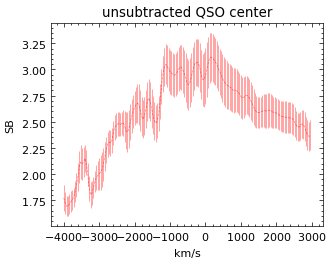

In [135]:

plt.errorbar(xnew,result_QSO[0][cind,:],yerr=result_QSO[2][cind,:]*efactor*ccfac,fmt="--",mfc='none',ms=0.5,color="r",ecolor="r",lw=0.5,alpha=0.5)
plt.title("unsubtracted QSO center")
plt.xlabel("km/s")
plt.ylabel("SB")

In [90]:
ccfac

0.00026792966824128

In [84]:
sigma_clipped_stats(result_QSO[0][xind,:],maxiters=None)

(0.0002998706575426248, 0.00028432969011940785, 0.00017391406835504824)

## Inspect each cubes in cube space (around restframe 1216)

In [8]:
Lya_SB={}
annulus_bin={}
annulus_value={}

In [10]:
import regions
from regions.shapes.circle import CircleSkyRegion,CirclePixelRegion
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion, RectangleSkyRegion
from regions import PixCoord
import re
type="HLQSO"

qso_low=ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
# radius bin
#rbin=np.logspace(-0.5,0.48,num=6)
rbin=np.arange(0.3,6.9,0.3)
# windowsize to extract the Lya nebulae
windowsize=13.8*u.arcsec

# extract -500 to -2000 km/s profile
vup=3100
vlow=-4100
cw=1215.67

for ind,sourcename in enumerate(QSOtab['Name']):
    if "Q1623" in sourcename:
        continue
        field="Q1623"
        psname=re.findall(r"-(.*)",sourcename)[0]
        sentry=qsos[(qsos["Field"]==field) & (qsos["Name"]==field+"-"+psname)]
        ssentry=qso_low[qso_low["Name"]==psname]
        csname=ssentry["Cube"][0]
        datapath=KBSSpath+"/"+field+"/"+csname+"/kcwi_oned"
        subdapath=KBSSpath+"/"+field+"/"+psname+"/kcwi_oned"
    else:
        sentry=qsos[qsos["Name"]==sourcename]
        field=sentry["Field"][0]        
        subdapath=KBSSpath+"/"+field+"/QSO"
        datapath=KBSSpath+"/"+field+"/QSO"
        csname="qso"
        psname="qso"


    contam=sentry["contam"][0]

    if contam=="True":
        continue
    Subfile = subdapath+"/{}-{}_icubes_wcs_20.PSFCONTSub.fits".format(field.lower(),psname)
    varfile=datapath+"/{}-{}_vcubes.fits".format(field.lower(),csname)
    
    
    
    O_cube = SpectralCube.read(Subfile)
    OV_cube = SpectralCube.read(varfile)
    wcsinfo = O_cube.wcs.celestial
    RA = sentry["RA"].value[0]
    Dec = sentry["Dec"].value[0]
    redshift=sentry["z_sys"].value[0]
    xpix = sentry["x"].value[0]
    ypix = sentry["y"].value[0]
    s_coord=PixCoord(x=xpix,y=ypix)
    sc=s_coord.to_sky(wcsinfo) #redefine PSF center as the source center
    #sc=SkyCoord(ra=RA, dec=Dec, unit='deg',frame="icrs", equinox='J2000')
    #sregion=regions.RectangleSkyRegion(sc,width=windowsize, height=windowsize)
    #sregion_pix=sregion.to_pixel(wcsinfo)
    pixel_scale=wcsinfo.pixel_scale_matrix[1,1]*3600
    sregion_pix=regions.RectanglePixelRegion(center=s_coord,width=windowsize.value/pixel_scale, height=windowsize.value/pixel_scale)

    
    
    Sub_cube=O_cube.subcube_from_regions([sregion_pix])
    Var_cube=OV_cube.subcube_from_regions([sregion_pix])
    
    wcssub=Sub_cube.wcs.celestial
    
    specwidth=1
    cw=1215.67*(1+redshift) * u.AA
    wc = Sub_cube.spectral_axis.value
    vc = (wc / (1 + redshift) - 1215.67) / 1215.67 *3e5

    windex = (vlow<vc)&(vup>vc)
    wmin=np.min(wc[windex])*u.AA
    wmax=np.max(wc[windex])*u.AA
    #Lya_varcube = Var_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subvarcube = Var_cube.spectral_slab(wmin,wmax)
    #Lya_cube = Sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subcube = Sub_cube.spectral_slab(wmin,wmax)

    
    Lya_mvar = Lya_subvarcube.unmasked_data[:].value
    Lya_mflux = Lya_subcube.unmasked_data[:].value

    #mask=Lya_mflux.value > 1.0*Lya_msig.value
    #bad=np.isnan(Lya_moment_1[mask])
    Lya_SB[sourcename]=[Lya_mflux, Lya_mvar, wcssub, vc[windex]]

    # Log scaled radius SB profile
    Aregions=[]
    Aregions_value=[]
    Aregions_varvalue=[]
    for rind, rin in enumerate(rbin):
        if rind<len(rbin)-1:
            region_annulus_sky = CircleAnnulusSkyRegion(center=sc,
                                                inner_radius=rin * u.arcsec,
                                                outer_radius=rbin[rind+1] * u.arcsec)
            region_annulus_pix = region_annulus_sky.to_pixel(wcssub)
            #region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=xpix,y=ypix),inner_radius=rin/0.3,outer_radius=rbin[rind+1]/0.3)
            Aregions.append(region_annulus_pix)
            Lya_mflux_sub=Lya_subcube.subcube_from_regions([region_annulus_pix]).unmasked_data[:].value
            Lya_mvar_sub=Lya_subvarcube.subcube_from_regions([region_annulus_pix]).unmasked_data[:].value
            Aregions_value.append(Lya_mflux_sub)
            Aregions_varvalue.append(Lya_mvar_sub)
        else:
            continue
    annulus_bin[sourcename]=Aregions
    annulus_value[sourcename]=[Aregions_value,Aregions_varvalue]
#    mask_annulus_reg = region_annulus_pix.to_mask()
#    mask_annulus_reg = mask_annulus_reg.to_image(Sub_cube.shape[1:]).astype(bool)







In [760]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"


for ind,sourcename in enumerate(QSOtab['Name']):
    if "Q1623" in sourcename:
        field="Q1623"
        psname=re.findall(r"-(.*)",sourcename)[0]
        sentry=qsos[(qsos["Field"]==field) & (qsos["Name"]==field+"-"+psname)]
        ssentry=qso_low[qso_low["Name"]==psname]
        csname=ssentry["Cube"][0]
        datapath=KBSSpath+"/"+field+"/"+csname+"/kcwi_oned"
        subdapath=KBSSpath+"/"+field+"/"+psname+"/kcwi_oned"
    else:
        sentry=qsos[qsos["Name"]==sourcename]
        field=sentry["Field"][0]        
        subdapath=KBSSpath+"/"+field+"/QSO"
        datapath=KBSSpath+"/"+field+"/QSO"
        csname="qso"
        psname="qso"

    contam=sentry["contam"][0]
    if contam == "True":
        continue
    Subfile = subdapath+"/{}-{}_icubes_wcs.PSFCONTSub.fits".format(field.lower(),psname)
    O_cube = SpectralCube.read(Subfile)
    wcsinfo = O_cube.wcs.celestial
    RA = sentry["RA"].value[0]
    Dec = sentry["Dec"].value[0]
    redshift=sentry["z_sys"].value[0]
    
    xpix = sentry["x"].value[0]
    ypix = sentry["y"].value[0]
    s_coord=PixCoord(x=xpix,y=ypix)
    sc=s_coord.to_sky(wcsinfo)
    
    #sregion_pix=regions.RectanglePixelRegion(center=s_coord,width=windowsize.value/pixel_scale, height=windowsize.value/pixel_scale)

    #Sub_cube=O_cube.subcube_from_regions([sregion_pix])
    
    wcssub=Lya_SB[sourcename][2]#Sub_cube.wcs.celestial
    pixel_scale=wcssub.pixel_scale_matrix[1,1]*3600
    vlow=-2000
    vup=-670
    vc=Lya_SB[sourcename][3]
    vindex=(vlow<vc)&(vup>vc)

    
    Lya_mflux=np.nansum(Lya_SB[sourcename][0][vindex,:,:],axis=0)
    #Lya_msig=Lya_SB[sourcename][1]
    _, med, std = sigma_clipped_stats(Lya_mflux*100)
    
    #mask=Lya_mflux.value < std*0.07
   # mask=Lya_mflux < 1.*Lya_msig
    # Integrated Lya image
    
    
    
    fig, ax, im1 = imshow_astro(Lya_mflux*100,wcssub , cblabel = Lyau, colorbar=True, vrange = (-0.1, med+10*std),cmap = "binary")
        
    #s_coord3=wcsinfo.world_to_pixel(sc3)
    #ax.plot(s_coord3[0],s_coord3[1],"+",c="r",ms=30,lw=0.1)
    #for aregion in Aregions:
    #    ax.add_artist(aregion.as_artist(facecolor='none', edgecolor='green'))
    ns_coord=sc.to_pixel(wcssub)
    ax.plot(ns_coord[0],ns_coord[1],"+",c="g",ms=30,lw=0.1)
    ax.text(ns_coord[0]+2,ns_coord[1]-3
            ,"{}".format(sourcename),color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)
    
    
    #ax.scatter(sc3.ra.value, sc3.dec.value, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')
    #ax.text(sc3.ra.value, sc3.dec.value,"{}-{}".format(cubename,tag3),color="red",transform=ax.get_transform('world'),verticalalignment='bottom',horizontalalignment='right',fontsize=15)
    
    
    
    x0, y0 = 15, 15
    arrow_length = 3
    
    # North arrow goes upward in y-direction (positive Dec)
    ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
    ax.text(x0+1, y0+1, 'N', color='black', ha='center', va='bottom')
    # East arrow goes to the right in x-direction (negative RA)
    ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
    ax.text(x0-1, y0-1, 'E', color='black', ha='center', va='top')
    
    #region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=ns_coord[0],y=ns_coord[1]),inner_radius=rbin[rbin1]/pixel_scale,outer_radius=rbin[rbin2]/pixel_scale)
    #ax.add_artist(region_annulus_pix.as_artist(facecolor='none', edgecolor='green'))
    #print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
    #-------------------Reference scale setting----------------#
    dT = 10  # kpc distance
    delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
    start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
    start_coord = wcssub.pixel_to_world(start_x, start_y)
    end_coord = wcssub.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel
    
    delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
    length_in_pixels = delta_theta_deg / delta_ra_per_pixel
    
    ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='red', lw=2)
    ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='red', ha='center', va='bottom')
    
    ax.set_xlabel("R.A.")
    ax.set_ylabel("Dec.")
    
    ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$(z={})".format(1216,round(redshift,2)))
    fig.savefig(KBSSpath+f"/QSOs_r{radius}_masked/Lya_blue_{sourcename}.pdf")
    plt.close()
    #plt.show()

In [87]:
from scipy import interpolate
tab=QSOtab#qsos[(qsos['contam']=="False")&(qsos['Field']!="Q1623")]
stackx = np.arange(0,13.8, 0.15)
stacky = np.arange(0,13.5,0.15)
vstack1 = np.arange(-4000,3000,50)
rbin1=17
rbin2=18
#vlow=-2000
#vup=-670
nboot=100
vlow=-2000
vup=-500
dospec=True
doimg=True
stackcube=np.zeros((len(tab), len(stacky), len(stackx)))
spec_to_stack=np.zeros((rbin2-rbin1,len(vstack1)))
stackspec=np.zeros((len(tab), len(vstack1)))
for ind,sourcename in enumerate(tab['Name']):
    if "Q1623" in sourcename:
        print("skipping",sourcename)
        continue
    wcssub=Lya_SB[sourcename][2]
    pixel_scale=wcssub.pixel_scale_matrix[1,1]*3600
    vc=Lya_SB[sourcename][3]
    if dospec:
        for sind,item in enumerate(annulus_value[sourcename][0][rbin1:rbin2]):
            interpfunc_spec=interpolate.CubicSpline(vc,np.nanmean(item,axis=(1,2)))
            spec_to_stack[sind,:] = interpfunc_spec(vstack1)
        stackspec[ind,:] = np.nanmean(spec_to_stack,axis=0)
    if doimg:
        vindex=(vlow<vc)&(vup>vc)
        img_to_stack=np.nansum(Lya_SB[sourcename][0][vindex,:,:],axis=0)
        xshape, yshape=img_to_stack.shape
        xstack = np.linspace(1,xshape,xshape)*pixel_scale
        ystack = np.linspace(1,yshape,yshape)*pixel_scale
        interpfunc = interpolate.interp2d(xstack, ystack, np.nan_to_num(img_to_stack.T), kind='cubic')
        cube2d_new = interpfunc(stackx, stacky)
        stackcube[ind, :, :] = cube2d_new
        

stackfunc=np.nanmean
    #Lya_mflux=
if doimg:
    cspace_stack = np.nanmean(stackcube,axis=0).T
    if nboot is not None:
        bootcube = np.zeros((nboot, len(stacky), len(stackx)))
        for i in range(nboot):
            rand = np.random.randint(0, len(tab)-1, size=len(tab))
            stackcube_rearrange = stackcube[rand, :, :]
            bootcube[i, :, :] = stackfunc(stackcube_rearrange, axis=0)
        
        imgerr = np.nanstd(bootcube, axis=0).T






if dospec:
    cspace_specstack = np.nanmean(stackspec,axis=0)
    if nboot is not None:
        bootcube = np.zeros((nboot, len(vstack1)))
        for i in range(nboot):
            rand = np.random.randint(0, len(tab)-1, size=len(tab))
            stackcube_rearrange = stackspec[rand, :]
            bootcube[i, :] = stackfunc(stackcube_rearrange, axis=0)
        
        specerr = np.nanstd(bootcube, axis=0)



In [19]:
img_to_stack.shape

(69, 69)

highlighting annulus region in: 5.3999999999999995 5.699999999999999 arcsec


Text(0.5, 1, 'Integrated KCWI slice around 1216$\\rm\\,\\AA\\,$ (-2000 to -500 km/s)')

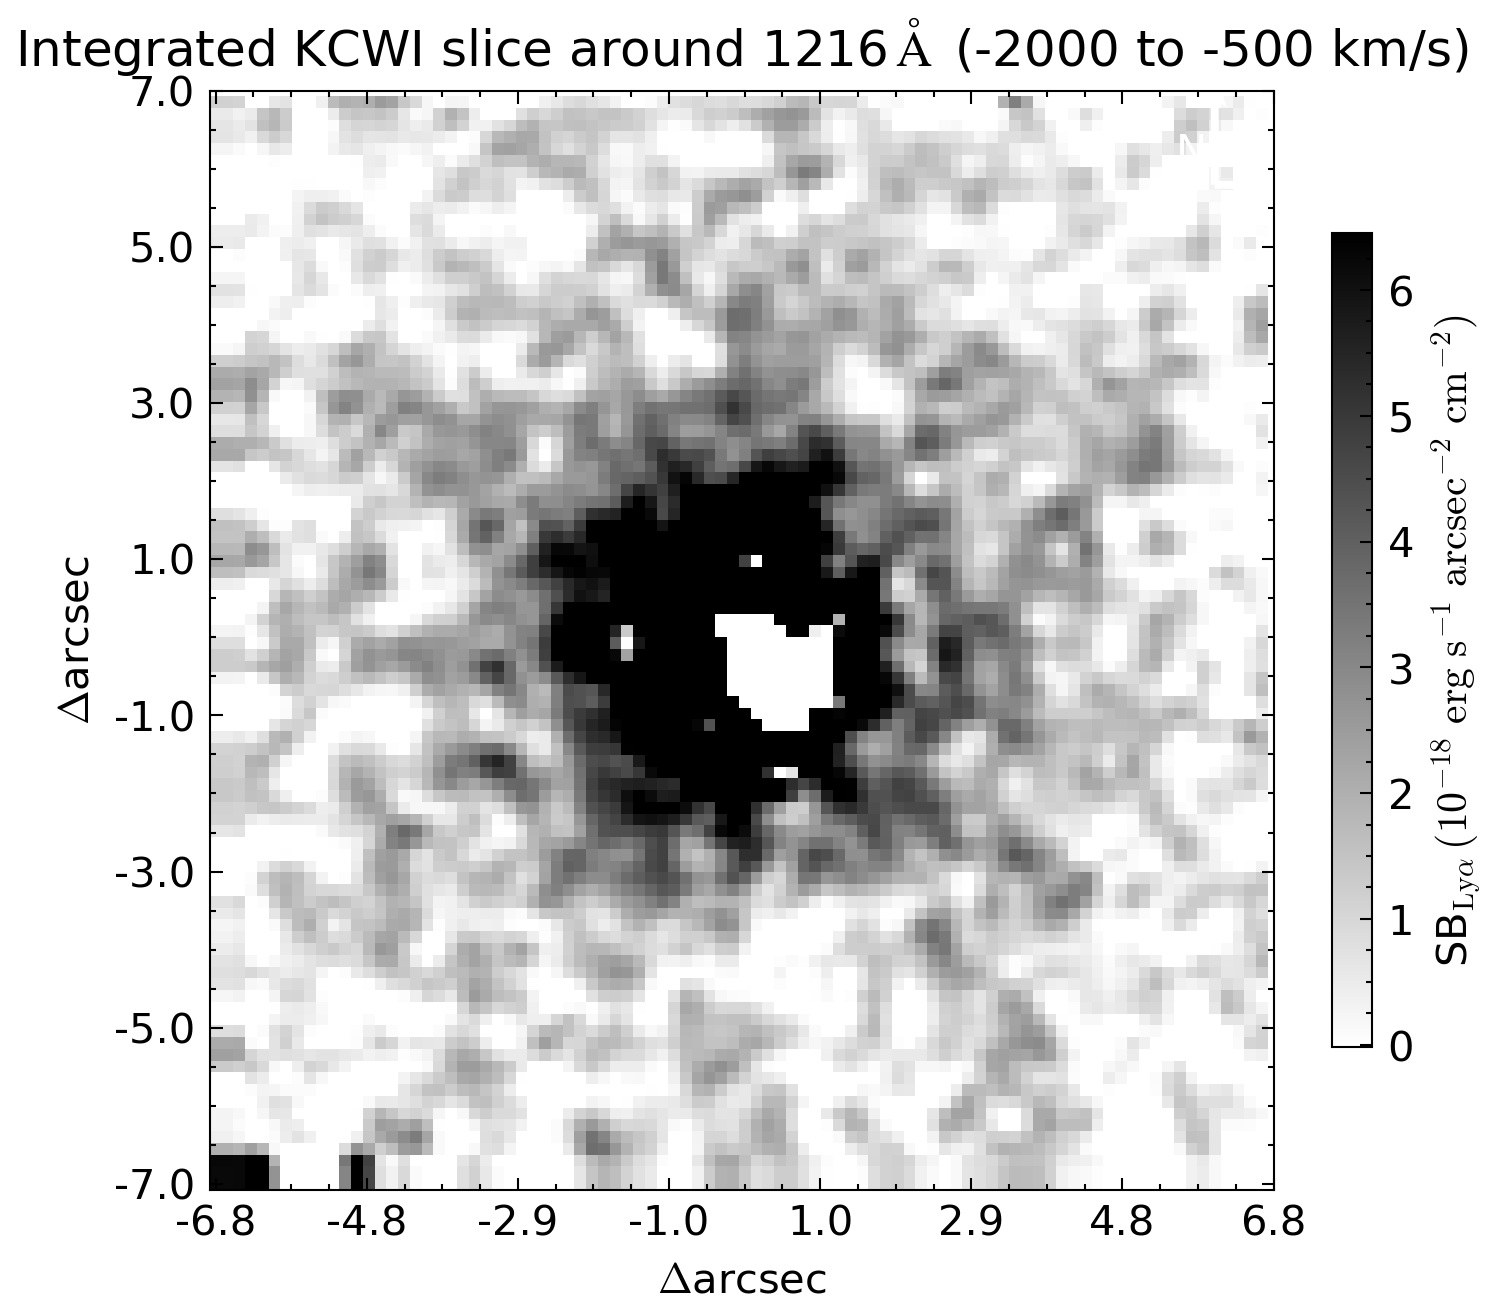

In [88]:

plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})
Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"

_, med, std = sigma_clipped_stats(cspace_stack*100,maxiters=100)
pix_scale=[0.15,0.15]
fig, ax = imshow_ifu(cspace_stack*100,figsize = (5,5),dpi=300,pix_scale=pix_scale, cblabel = Lyau, colorbar=True, vrange = (-0.02, 5*std),cmap = "binary")
    
#s_coord3=wcsinfo.world_to_pixel(sc3)
#ax.plot(s_coord3[0],s_coord3[1],"+",c="r",ms=30,lw=0.1)
#for aregion in Aregions:
#    ax.add_artist(aregion.as_artist(facecolor='none', edgecolor='green'))
ns_coord=sc.to_pixel(wcssub)
#ax.plot(ns_coord[0],ns_coord[1],"+",c="g",ms=30,lw=0.1)
#ax.text(ns_coord[0]+2,ns_coord[1]-3
        #,"{}".format(sourcename),color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)


#ax.scatter(sc3.ra.value, sc3.dec.value, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')
#ax.text(sc3.ra.value, sc3.dec.value,"{}-{}".format(cubename,tag3),color="red",transform=ax.get_transform('world'),verticalalignment='bottom',horizontalalignment='right',fontsize=15)

#rbin1=13
#rbin2=20
inner=4.2
outer=6.2
#region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=cspace_stack.shape[0]/2,y=cspace_stack.shape[1]/2),inner_radius=inner/pix_scale[0],outer_radius=outer/pix_scale[0])
region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=cspace_stack.shape[0]/2,y=cspace_stack.shape[1]/2),inner_radius=rbin[rbin1]/pix_scale[0],outer_radius=rbin[rbin2]/pix_scale[0])
#ax.add_artist(region_annulus_pix.as_artist(facecolor='none', edgecolor='green'))
print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
# North arrow goes upward in y-direction (positive Dec)
#ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
#ax.text(x0+1, y0+1, 'N', color='black', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
#ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
#ax.text(x0-1, y0-1, 'E', color='black', ha='center', va='top')


#-------------------Reference scale setting----------------#
dT = 10  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcssub.pixel_to_world(start_x, start_y)
end_coord = wcssub.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

#ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='red', lw=2)
#ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='red', ha='center', va='bottom')

#ax.set_xlabel("R.A.")
#ax.set_ylabel("Dec.")
fig.savefig(KBSSpath+"/QSOs_r{}_masked/stacked_img_blue.pdf".format(radius))
ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$ ({} to {} km/s)".format(1216,vlow,vup))

<function lya_model_2 at 0x7f1dc1fc38c0>
highlighting annulus region in: 5.3999999999999995 5.699999999999999 arcsec


(-0.3, 1)

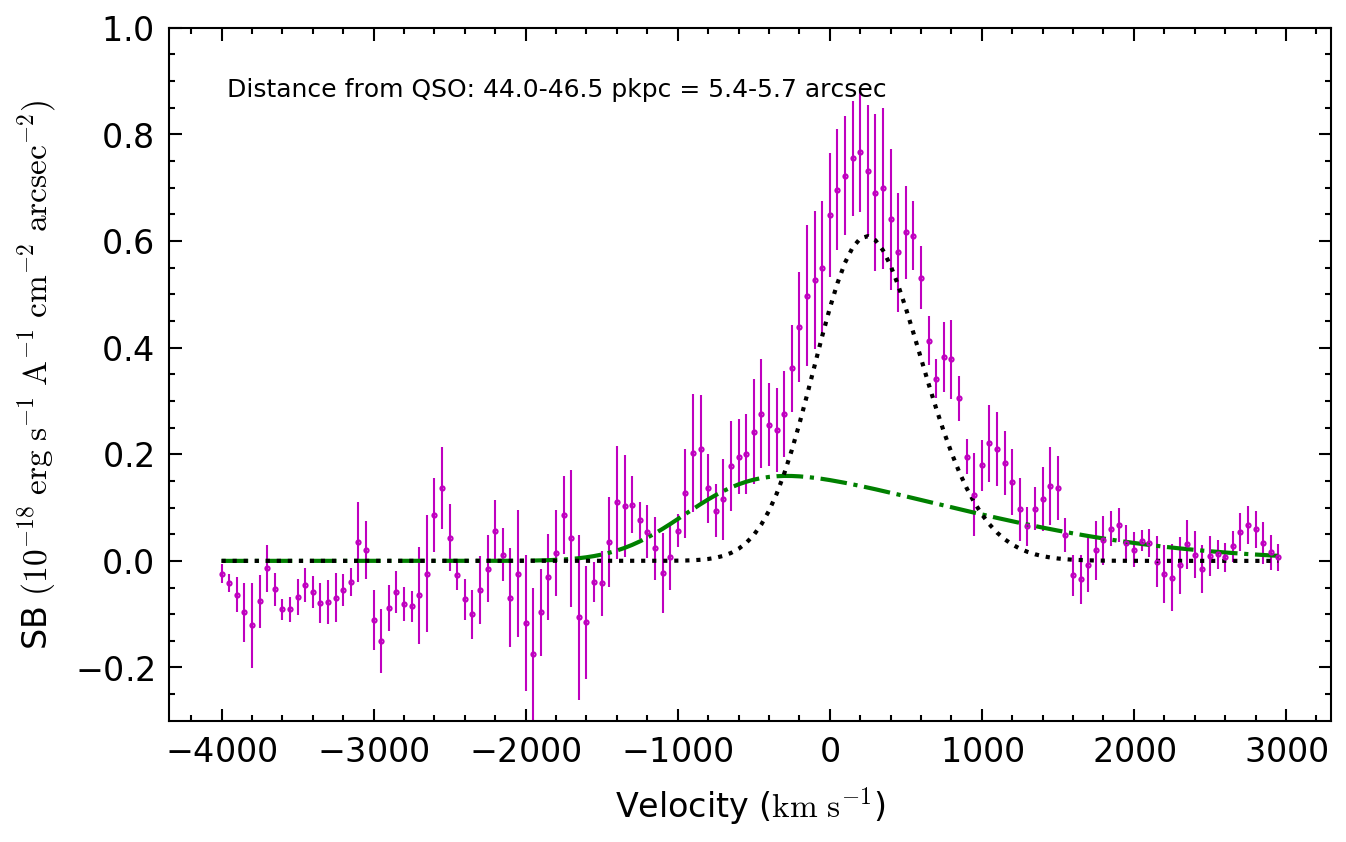

In [83]:
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60
fig, ax = plt.subplots(figsize=(5,3),dpi=300)
p0,p0sig=common_tools_yd.fit_lya_2(vstack1,cspace_specstack*100,specerr*100,absolute_sigma=False, all_p=True)

fitmodel0, lyamodel0, ndim0, p0, pcov0=common_tools_yd.lya_bestmod(vstack1,cspace_specstack*100,specerr*100, plot=False)

#ax.plot(vstack1,mod,"--C1",label="Full model")
ax.errorbar(vstack1,cspace_specstack*100,yerr=specerr*100,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
mod = lyamodel0(vstack1, *p0)
print(lyamodel0)
mod1 = common_tools_yd.skew_gauss(vstack1,*p0[:4])
mod2 = common_tools_yd.skew_gauss(vstack1, *p0[4:])
ax.plot(vstack1,mod1,"g",ls="-.")
ax.plot(vstack1,mod2,"k",ls=":")

ax.text(0.05,0.9,f"Distance from QSO: {rbin[rbin1]*kpc_per_arcsec:.1f}-{rbin[rbin2]*kpc_per_arcsec:.1f} pkpc = {rbin[rbin1]:.1f}-{rbin[rbin2]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

#mod = common_tools_yd.skew_gauss(vstack1, *p0)
#ax.plot(vstack1,mod,"m",ls="--")
#ax.axhline(y=0,c="r")
#for sind in range(stackspec.shape[0]):
    #ax.errorbar(vstack1,stackspec[sind,:]*100,fmt="-o",mfc='none',ms=0.5,color="C{}".format(sind),ecolor="m",lw=0.5)
#ax.legend(loc="right")
ax.set_xlabel(r"Velocity ($\rm km~s^{-1}$)")
ax.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$")
print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
#ax.set_xlim([-3000,3000])
ax.set_ylim([-0.3,1])
#ax.text(0.05,0.85,string,transform=ax.transAxes,color="k",fontsize=6)
#ax.text(0.05,0.75,f"Distance from QSO: {ynew[xind]*kpc_per_arcsec:.1f} pkpc = {ynew[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

In [53]:
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})



kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60

spec
fig, ax = plt.subplots(figsize=(5,3),dpi=300)

p0,p0sig=common_tools_yd.fit_lya_2(vstack1,cspace_specstack*100,specerr*100,absolute_sigma=False, all_p=True)

fitmodel0, lyamodel0, ndim0, p0, pcov0=common_tools_yd.lya_bestmod(vstack1,cspace_specstack*100,specerr*100, plot=False)

#ax.plot(vstack1,mod,"--C1",label="Full model")
ax.errorbar(vstack1,cspace_specstack*100,yerr=specerr*100,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
mod = lyamodel0(vstack1, *p0)
print(lyamodel0)
mod1 = common_tools_yd.skew_gauss(vstack1,*p0[:4])
mod2 = common_tools_yd.skew_gauss(vstack1, *p0[4:])
ax.plot(vstack1,mod1,"g",ls="-.")
ax.plot(vstack1,mod2,"k",ls=":")

ax.text(0.05,0.9,f"Distance from QSO: {rbin[rbin1]*kpc_per_arcsec:.1f}-{rbin[rbin2]*kpc_per_arcsec:.1f} pkpc = {rbin[rbin1]:.1f}-{rbin[rbin2]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

#mod = common_tools_yd.skew_gauss(vstack1, *p0)
#ax.plot(vstack1,mod,"m",ls="--")
#ax.axhline(y=0,c="r")
#for sind in range(stackspec.shape[0]):
    #ax.errorbar(vstack1,stackspec[sind,:]*100,fmt="-o",mfc='none',ms=0.5,color="C{}".format(sind),ecolor="m",lw=0.5)
#ax.legend(loc="right")
ax.set_xlabel(r"Velocity ($\rm km~s^{-1}$)")
ax.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$")
print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
#ax.set_xlim([-3000,3000])
ax.set_ylim([-0.3,1])
#ax.text(0.05,0.85,string,transform=ax.transAxes,color="k",fontsize=6)
#ax.text(0.05,0.75,f"Distance from QSO: {ynew[xind]*kpc_per_arcsec:.1f} pkpc = {ynew[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

(<function common_tools_yd.fit_lya_05(vel, spec, spec_sig, all_p=False, absolute_sigma=False)>,
 <function common_tools_yd.sym_gauss(vel, v0, sigv, height, a0=None, a1=None, a2=None, a3=None, a4=None)>,
 3,
 array([ 2.03367047e+02,  5.02556733e+02,  0.00000000e+00,  2.49927911e+00,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03, -9.99900000e+03]),
 array([[ 5.82481825e+02, -1.00709144e+02, -9.99900000e+03,
         -5.24139126e-01, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03],
        [-1.00709144e+02,  5.55820427e+02, -9.99900000e+03,
         -2.13547336e+00, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03],
        [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03],
        [-5.24139126e-01, -2.13547336e+00, -9.99900000e+03,
          1.98062229e-02, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -

In [55]:
p0

array([-8.11135524e+01,  9.40166648e+02,  7.70879222e+00,  5.56151971e-01,
        5.34132956e+02,  7.25096840e+02, -2.57317023e+00,  1.14722095e+00])

In [431]:
2.*np.max(cspace_specstack)

0.021221714813292224

In [318]:
rbin

array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6, 3.9,
       4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. , 6.3])

In [319]:
region_annulus_sky = CircleAnnulusSkyRegion(center=sc,
                                            inner_radius=0.3 * u.arcsec,
                                            outer_radius=0.6 * u.arcsec)
region_annulus_pix = region_annulus_sky.to_pixel(wcssub)

In [325]:
wcssub.pixel_scale_matrix*3600

array([[-0.2,  0. ],
       [ 0. ,  0.2]])

In [348]:
wcsinfo.pixel_scale_matrix[1,1]*3600

0.200000000000016

In [349]:
pixel_scale

-0.200000000000016